# Section 0: Data Set Up

In [1]:
import pandas as pd
import numpy as np
import re
import string
import json
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

In [2]:
file_name = "config/party_map.json"
with open(file_name, 'r') as file:
    party_mapper = json.load(file)

file_name = '../data/sentiment_scores/output_sentiment_clean.csv'
df = pd.read_csv(file_name)
    
df["party"] = df["politician"].map(party_mapper)
df = df.drop(columns=['topic_0_score', 'topic_1_score', 'topic_2_score', 'topic_3_score','topic_4_score',
                      'topic_5_score', 'topic_6_score', 'cluster', 'tsne_x','tsne_y', 'dominant_topic_lda'])
df = df.dropna(subset=['text'])
df['year'] = df['file_name'].str.extract(r'(20\d{2})', expand=False)
df['year'] = pd.to_numeric(df['year'], errors='coerce')

name_map = {
    'bernie_sanders': 'sanders_bernie',
    'ted_cruz': 'cruz_ted',
    'marco_rubio': 'rubio_marco',
    'elizabeth_warren': 'warren_elizabeth',
    'mitch_mcconnell': 'mcconnell_mitch',
    'chuck_schumer': 'schumer_chuck',
    'jd_vance': 'vance_jd',
    'andrew_cuomo': 'cuomo_andrew'
}
df['politician_standardized'] = df['politician'].map(name_map).fillna(df['politician'])

In [3]:
df.head(3)

politician           type_of_speech  \
0  king_angus_s_jr  partisan_rally_speeches   
1  king_angus_s_jr  partisan_rally_speeches   
2  king_angus_s_jr  partisan_rally_speeches   

                                           file_name  \
0  "now_is_the_time_to_establish_a_redline_—_the_...   
1  Gov._angus_king_speaking_at_a_rally_in_portlan...   
2     Founding_fathers_cold_open_-_snl_processed.txt   

                                                text   sadness       joy  \
0  the senate for maine is recognized. we all beg...  0.124538  0.320375   
1  angus king. the dogmas of the quiet past are i...  0.013997  0.270341   
2  nearly 250 years ago, delegates from the 13 am...  0.006786  0.759802   

       love     anger      fear  surprise        party    year  \
0  0.001485  0.482588  0.069628  0.001386  Independent     NaN   
1  0.002355  0.592581  0.118445  0.002281  Independent  2010.0   
2  0.002123  0.222126  0.006815  0.002348  Independent     NaN   

  politician_standardized  
0         king_angus_s_jr  
1         king_angus_s_jr  
2         king_angus_s_jr

# SECTION 1: Word Clouds

In [4]:
stopwords = set(STOPWORDS)
stopwords.update({
    'senator', 'president', 'speaker', 'bill', 'act', 
    'section', 'senate', 'house', 'states', 'united',
    'thank', 'thanks', 'will', 'one', 'said', 'going',
    'time', 'year', 'today', 'day', 'now',
    'amendment', 'subsection', 'sec', 'chair', 'may',
    'know', 'think', 'want', 'say', 'well', 'right',
    
})

def clean_text(text):
    if pd.isna(text):
        return ""
    
    text = text.lower()
    text = re.sub(r"[^\w\s]", " ", text)                 # remove punctuation
    text = re.sub(r"\d+", " ", text)                    # remove numbers
    words = text.split()
    words = [w for w in words if w not in stopwords and len(w) > 2]
    
    return " ".join(words)

df["clean_text"] = df["text"].apply(clean_text)

In [5]:
df["type_of_speech"].unique()

array(['partisan_rally_speeches', 'bipartisan_and_other_speeches',
       'house_floor_speeches', 'senate_floor_speeches'], dtype=object)

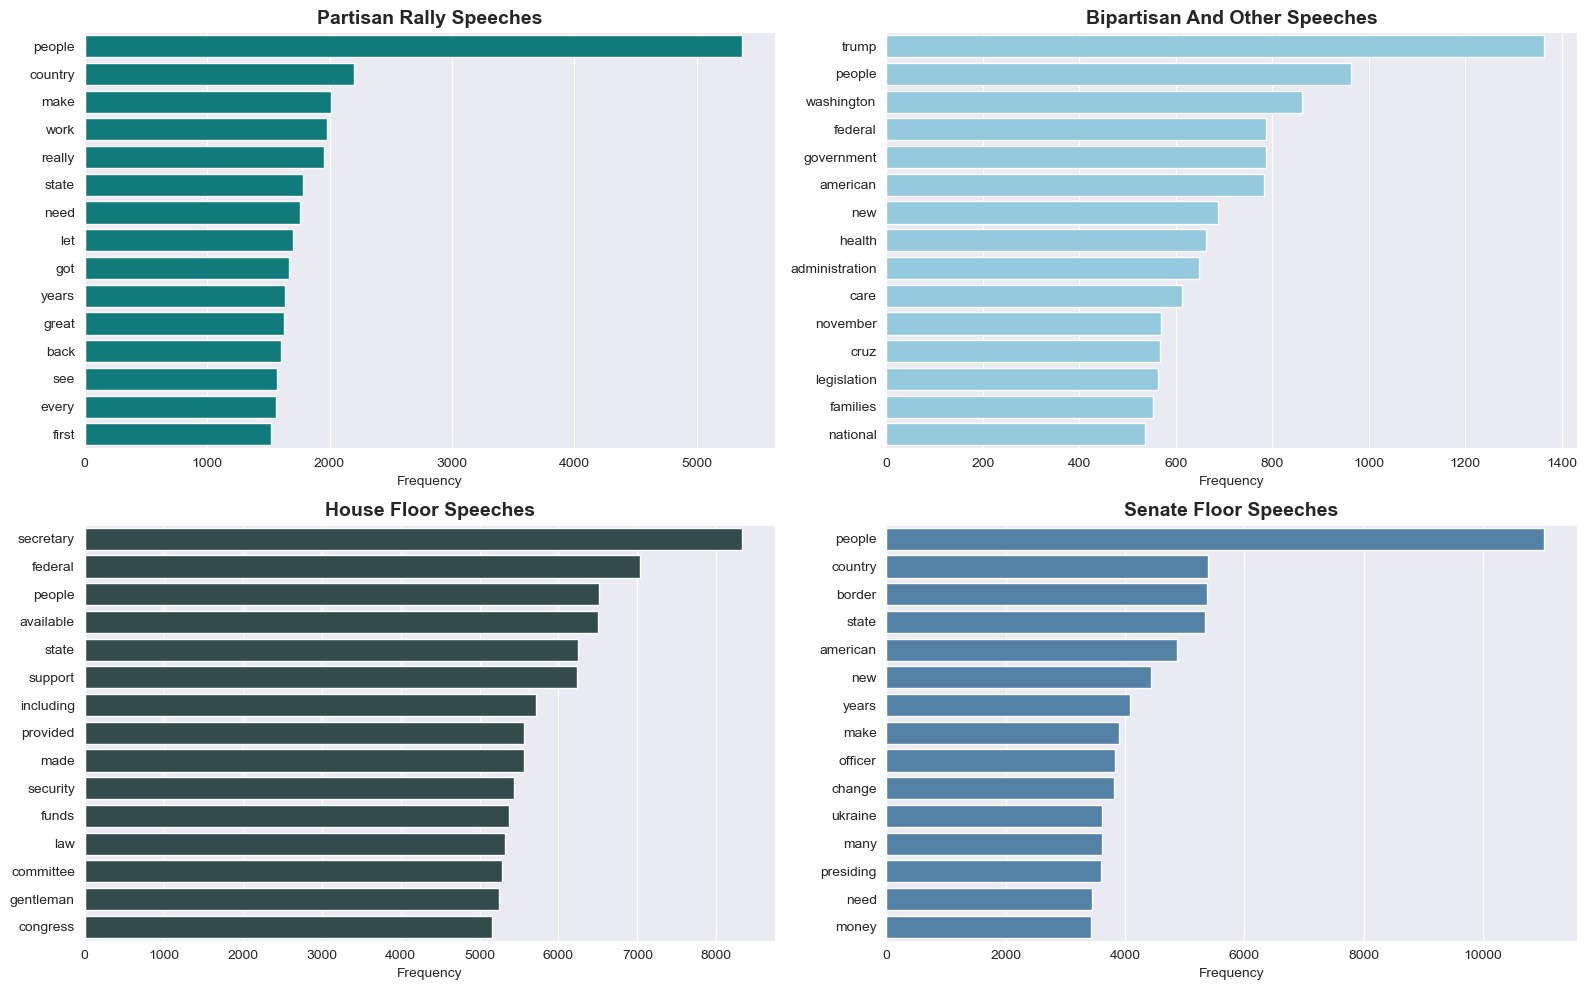

In [6]:
top_words_by_type = {}
colors_per_speech = {"partisan_rally_speeches":"darkcyan", "bipartisan_and_other_speeches":"skyblue",
                     "house_floor_speeches":"darkslategrey", "senate_floor_speeches":"steelblue"}
for speech_type in df["type_of_speech"].unique():
    subset = df[df["type_of_speech"] == speech_type]
    combined_text = " ".join(subset["clean_text"].tolist()).strip()
    words = combined_text.split()
    top_words_by_type[speech_type] = Counter(words).most_common(15)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()
for idx, speech_type in enumerate(df["type_of_speech"].unique()):
    words, counts = zip(*top_words_by_type[speech_type])
    
    sns.barplot(x=counts, y=words, ax=axes[idx], color=colors_per_speech[speech_type])
    axes[idx].set_title(speech_type.replace('_', ' ').title(), fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Frequency')

plt.tight_layout()
plt.show()

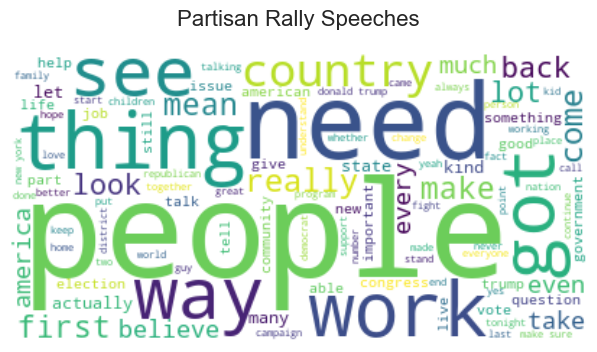

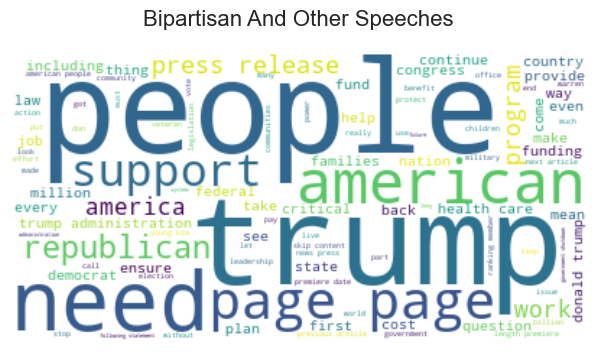

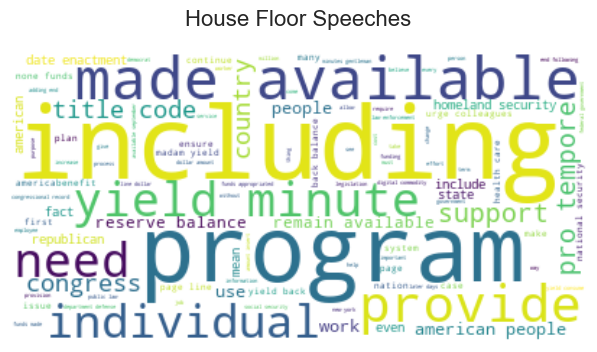

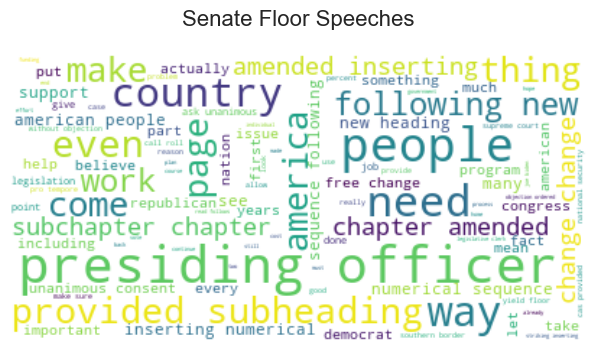

In [7]:
# In case we prefer wordclouds
speech_types = df["type_of_speech"].unique()

for index, speech_type in enumerate(speech_types):
    subset = df[df["type_of_speech"] == speech_type]
    combined_text = " ".join(subset["clean_text"].tolist()).strip()
    
    if len(combined_text.split()) == 0:
        print(f"Skipping {speech_type} because it has no usable words.")
        continue
    
    speech_type = str(speech_type).replace('_', ' ').capitalize()
    wordcloud = WordCloud(background_color="white", stopwords=stopwords, max_words=100).generate(combined_text)
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(speech_type.replace('_', ' ').title(), fontsize=16, pad=20)
    plt.tight_layout()
    plt.axis('off')
    plt.show()

In [8]:
# In case we wanna see the words
# def top_words(text, n=10):
#     words = text.split()
#     counts = Counter(words)
#     return counts.most_common(n)

# all_top_words_by_type = {}

# for stype in speech_types:
#     subset = df[df["type_of_speech"] == stype]
#     combined_text = " ".join(subset["clean_text"].tolist())
#     all_top_words_by_type[stype] = top_words(combined_text)

# all_top_words_by_type

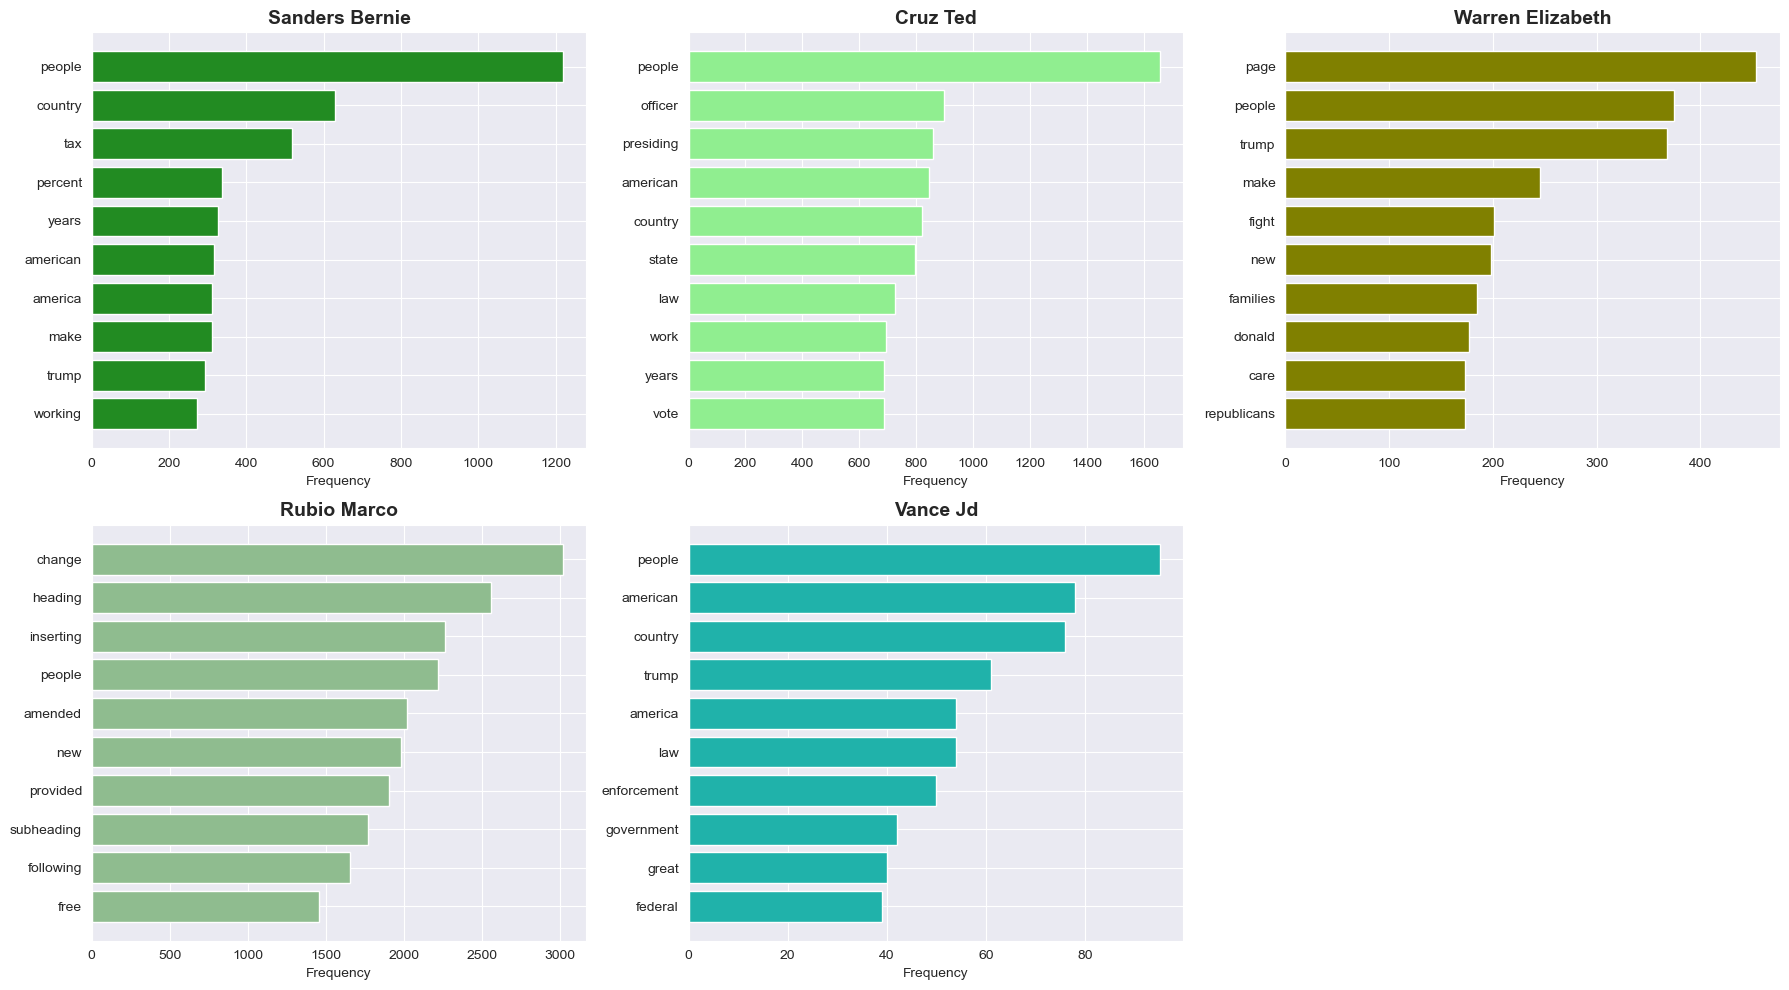

In [9]:
top_5 = ['sanders_bernie', 'cruz_ted', 'warren_elizabeth', 'rubio_marco', 'vance_jd']
colors_per_politician = {'sanders_bernie': 'forestgreen', 'cruz_ted': 'lightgreen', 'warren_elizabeth': 'olive', 'rubio_marco': 'darkseagreen', 'vance_jd': 'lightseagreen'}
top_words_by_politician = {}

for politician in top_5:
    subset = df[df['politician_standardized'] == politician]
    combined_text = " ".join(subset["clean_text"].tolist()).strip()
    
    if len(combined_text.split()) == 0:
        continue
    
    name_parts = set(politician.split('_'))
    words = combined_text.split()
    words = [w for w in words if w not in name_parts]
    top_words_by_politician[politician] = Counter(words).most_common(10)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, politician in enumerate(top_5):
    if politician not in top_words_by_politician:
        continue
    
    words, counts = zip(*top_words_by_politician[politician])
    
    axes[idx].barh(words, counts, color=colors_per_politician[politician])
    axes[idx].invert_yaxis()
    axes[idx].set_title(politician.replace('_', ' ').title(), fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Frequency')

axes[5].axis('off')

plt.tight_layout()
plt.show()


# Without top 10

# politicians = df["politician"].unique()

# for pol in politicians:
#     subset = df[df["politician"] == pol]
#     combined_text = " ".join(subset["clean_text"].tolist()).strip()
    
#     if len(combined_text.split()) == 0:
#         print(f"Skipping {pol} because it has no usable words.")
#         continue
    
#     print(f"Generating word cloud for: {pol}")
#     plot_wordcloud(combined_text, f"Top Words for Politician: {pol}")


In [10]:
# all_top_words_by_pol = {}

# for pol in top_5:
#     subset = df[df["politician"] == pol]
#     combined_text = " ".join(subset["clean_text"].tolist())
#     all_top_words_by_pol[pol] = top_words(combined_text)

# all_top_words_by_pol


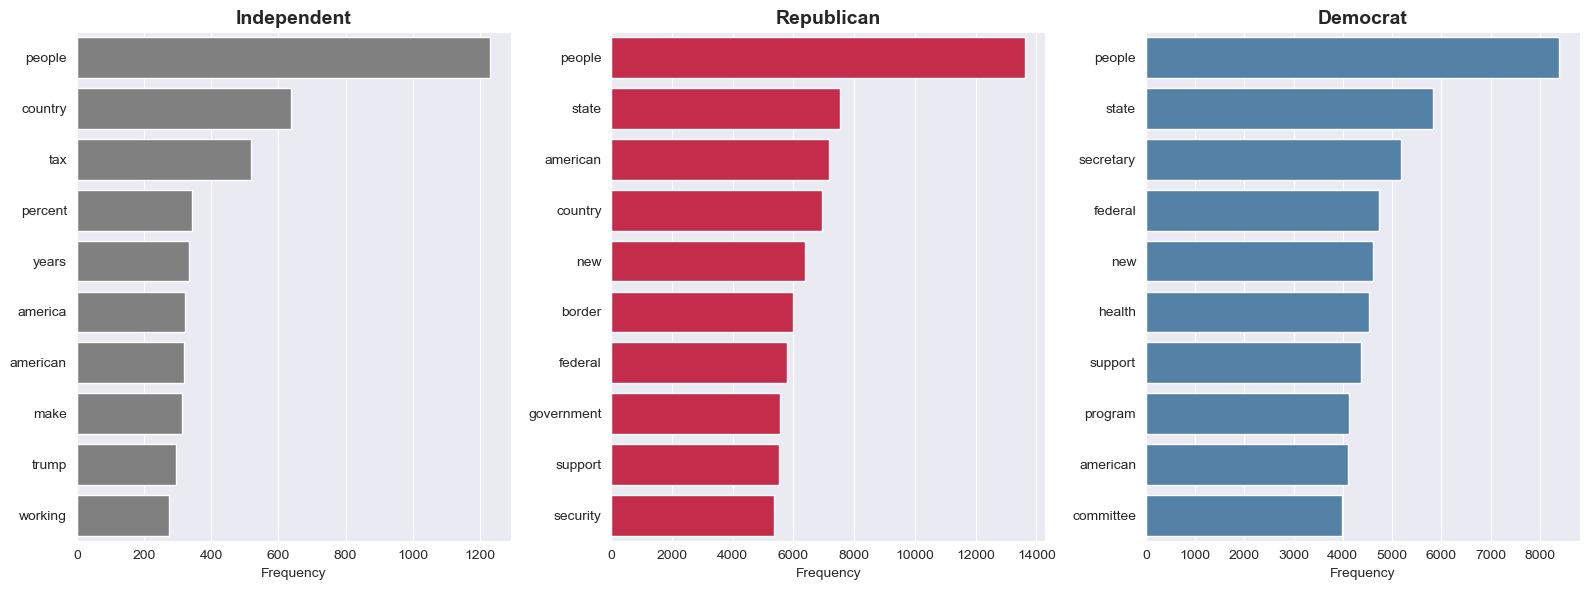

In [11]:
parties = df['party'].dropna().unique()
top_words_by_party = {}

for party in parties:
    subset = df[df['party'] == party]
    combined_text = " ".join(subset["clean_text"].tolist()).strip()
    
    if len(combined_text.split()) == 0:
        continue
    
    name_parts = set()
    for pol in df['politician_standardized'].unique():
        name_parts.update(pol.split('_'))
    
    words = combined_text.split()
    words = [w for w in words if w not in name_parts]
    top_words_by_party[party] = Counter(words).most_common(10)


fig, axes = plt.subplots(1, len(parties), figsize=(16, 6))
if len(parties) == 1:
    axes = [axes]

for idx, party in enumerate(parties):
    if party not in top_words_by_party:
        continue
    
    words, counts = zip(*top_words_by_party[party])
    if party in ['Democrat', 'Democratic']:
        color = 'steelblue'
    elif party in ['Republic', 'Republican']:
        color = 'crimson'
    else:
        color = 'grey'

    sns.barplot(x=counts, y=words, color=color, ax=axes[idx])
    axes[idx].set_title(party, fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Frequency')

plt.tight_layout()
plt.show()


# # Word clouds per party
# parties = df["party"].unique()

# for party in parties:
#     subset = df[df["party"] == party]
#     combined_text = " ".join(subset["clean_text"].tolist()).strip()
    
#     if len(combined_text.split()) == 0:
#         print(f"Skipping {party} because it has no usable words.")
#         continue
    
#     print(f"Generating word cloud for: {party}")
#     plot_wordcloud(combined_text, f"Top Words for Party: {party}")


# Section 1.5: Politicians to Analyze

In [12]:
emotions = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
politician_variation = []

for politician in df['politician_standardized'].unique():
    pol_data = df[df['politician_standardized'] == politician].copy()
    
    if len(pol_data) < 10 or pol_data['year'].nunique() < 3:
        continue
    
    variation_scores = []
    for emotion in emotions:
        std = pol_data[emotion].std()
        variation_scores.append(std)
    
    avg_variation = np.mean(variation_scores)
    politician_variation.append({
        'politician': politician,
        'avg_variation': avg_variation,
        'num_speeches': len(pol_data),
        'year_range': f"{pol_data['year'].min():.0f}-{pol_data['year'].max():.0f}"
    })

variation_df = pd.DataFrame(politician_variation)
variation_df = variation_df.sort_values('avg_variation', ascending=False)
high_var_1 = variation_df.iloc[0]['politician']
high_var_2 = variation_df.iloc[1]['politician']
low_var = variation_df.iloc[-1]['politician']

print(f"\nSelected politicians:")
print(f"High variation #1: {high_var_1}")
print(f"High variation #2: {high_var_2}")
print(f"Low variation: {low_var}")


Selected politicians:
High variation #1: gillibrand_kirsten_e
High variation #2: correa_j
Low variation: bera_ami


# SECTION 2: Speech Length and Sentence Length EDA

In [13]:
# Count words in each cleaned speech
df["word_count"] = df["clean_text"].apply(lambda x: len(x.split()))
df[["politician", "type_of_speech", "word_count"]].head()

politician                 type_of_speech  word_count
0  king_angus_s_jr        partisan_rally_speeches        1127
1  king_angus_s_jr        partisan_rally_speeches         223
2  king_angus_s_jr        partisan_rally_speeches         410
3  king_angus_s_jr  bipartisan_and_other_speeches          55
4  king_angus_s_jr  bipartisan_and_other_speeches          55

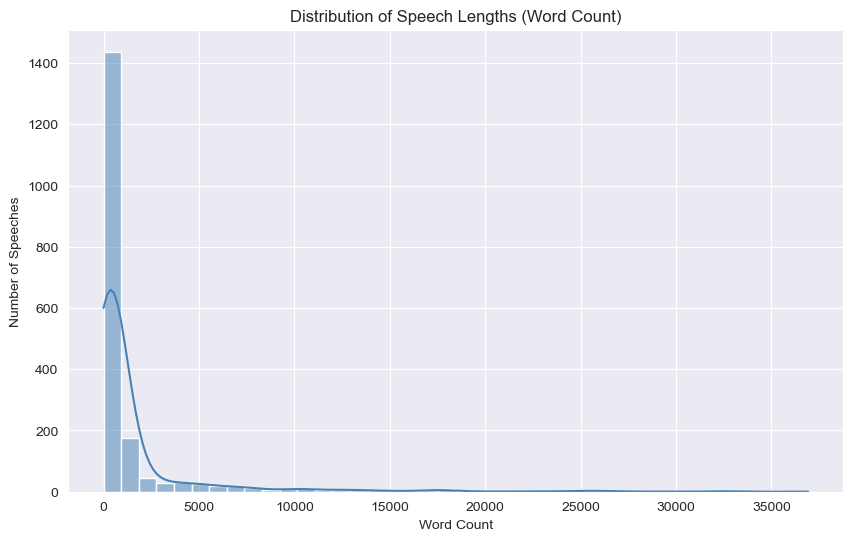

In [14]:
# There are some outliers so we are removing anything that out of the 98% threshold
df = df[df["word_count"] < 40000]

# Overall Distribution of Speech Lengths
plt.figure(figsize=(10, 6))
sns.histplot(df["word_count"], bins=40, kde=True, color="steelblue")
plt.title("Distribution of Speech Lengths (Word Count)")
plt.xlabel("Word Count")
plt.ylabel("Number of Speeches")
plt.show()


Text(0, 0.5, 'Politician')

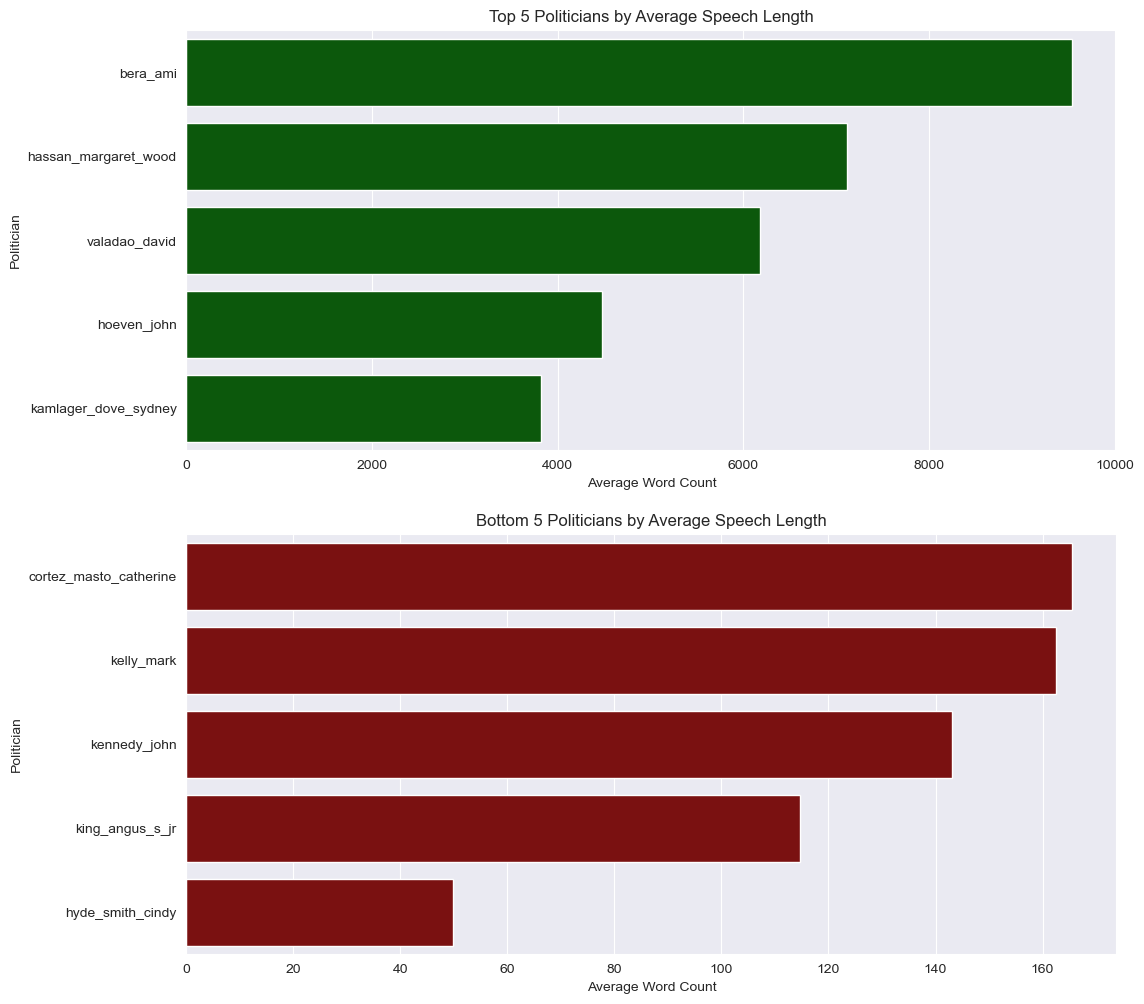

In [15]:
# Average Speech Length per Politician
avg_len_by_pol = df.groupby("politician")["word_count"].mean().sort_values(ascending=False).reset_index()

fig, ax = plt.subplots(2, 1, figsize=(12, 12))
ax = ax.flatten()
sns.barplot(avg_len_by_pol.head(5), x='word_count', y='politician', ax=ax[0], color='darkgreen')
ax[0].set_title("Top 5 Politicians by Average Speech Length")
ax[0].set_xlabel("Average Word Count")
ax[0].set_ylabel("Politician")

sns.barplot(avg_len_by_pol.tail(5), x='word_count', y='politician', ax=ax[1], color='darkred')
ax[1].set_title("Bottom 5 Politicians by Average Speech Length")
ax[1].set_xlabel("Average Word Count")
ax[1].set_ylabel("Politician")


In [16]:
# Longest Individual Speeches
df.nlargest(10, "word_count")[["politician", "file_name", "word_count"]]

politician                                          file_name  \
897    valadao_david  floor_2018_02_07_CREC_2018_02_07_pt1_PgH906_6_...   
2063        bera_ami  floor_2022_05_17_CREC_2022_05_17_pt1_PgHnull_1...   
722         ted_cruz  floor_2021_03_05_CREC_2021_03_05_pt1_PgS1219_2...   
963      marco_rubio  floor_2021_03_05_CREC_2021_03_05_pt1_PgS1219_2...   
1850        correa_j  floor_2017_03_24_CREC_2017_03_24_pt1_PgH2393_p...   
269   bernie_sanders     floor_2010_filibuster_the_speech_processed.txt   
912    valadao_david  floor_2021_01_06_CREC_2021_01_06_pt1_PgH76_4_p...   
694         ted_cruz  floor_2021_08_09_CREC_2021_08_09_pt1_PgS6061_7...   
757      johnson_ron  floor_2024_06_26_CREC_2024_06_26_pt1_PgH4167_3...   
1509     strong_dale  floor_2024_06_26_CREC_2024_06_26_pt1_PgH4167_3...   

      word_count  
897        36916  
2063       33018  
722        32508  
963        32508  
1850       32317  
269        29307  
912        27302  
694        26979  
757        25622  
1509       25622

In [ ]:
import spacy
from tqdm import tqdm

nlp = spacy.load("en_core_web_sm")
def avg_sentence_length_spacy(text):
    if pd.isna(text) or len(text.strip()) == 0:
        return np.nan
    doc = nlp(text)
    sentences = list(doc.sents)
    if len(sentences) == 0:
        return np.nan
    sentence_lengths = [len(sent) for sent in sentences]  # len(sent) counts tokens
    return np.mean(sentence_lengths)

tqdm.pandas()
df["avg_sentence_length"] = df["text"].progress_apply(avg_sentence_length_spacy)


# Can use instead of running the code above

# df = pd.read_csv("../data/sentiment_score/eda_dataset.csv")
# df.head(3)

  1%|▏         | 28/1877 [00:02<02:30, 12.32it/s]


KeyboardInterrupt: 

In [5]:
# Can use in case of running the code above

# df = pd.read_csv("../data/sentiment_scores/eda_dataset.csv")
# df.head(3)

In [19]:
# Remove Sentence Length Outliers and NAs
min_word_count = 80
df_clean = df[df["avg_sentence_length"] < min_word_count].dropna(subset=["avg_sentence_length"]).copy()

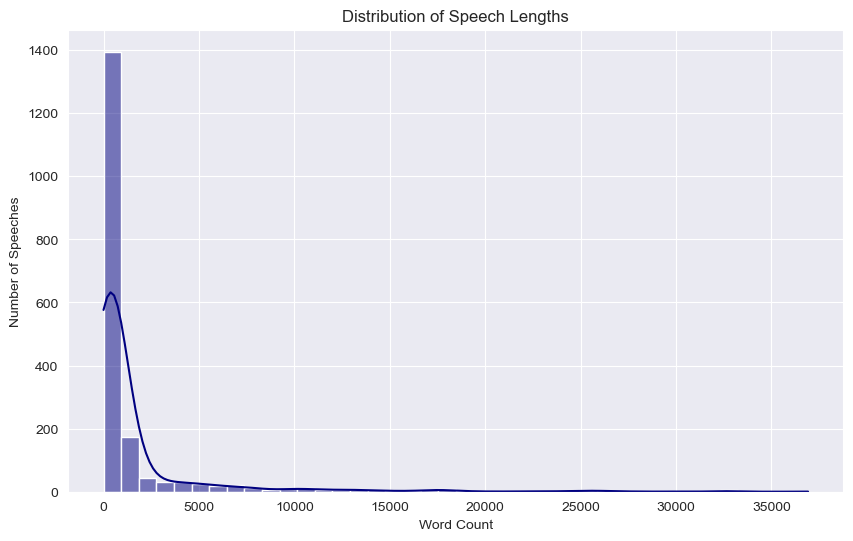

In [20]:
# Distribution of Word Count
plt.figure(figsize=(10, 6))
sns.histplot(df_clean["word_count"], bins=40, kde=True, color="navy")
plt.title("Distribution of Speech Lengths")
plt.xlabel("Word Count")
plt.ylabel("Number of Speeches")
plt.show()


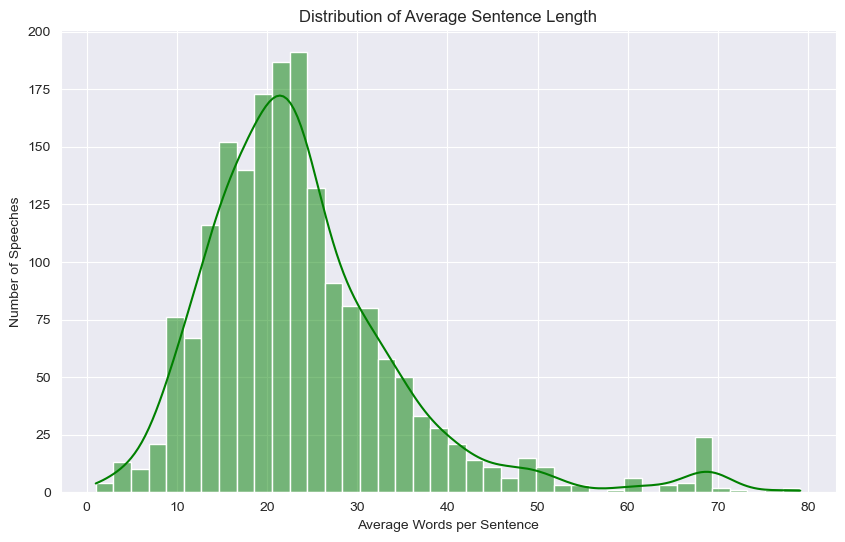

In [21]:
# Distribution of Sentence length

plt.figure(figsize=(10, 6))
sns.histplot(df_clean["avg_sentence_length"], bins=40, kde=True, color="green")
plt.title("Distribution of Average Sentence Length")
plt.xlabel("Average Words per Sentence")
plt.ylabel("Number of Speeches")
plt.show()


## PART A: Comparison by Political Party

In [22]:
# Average Word Count per Party
avg_wc_party = df_clean.groupby("party")["word_count"].mean().sort_values(ascending=False)
avg_wc_party

party
Republican     1689.980022
Democrat       1413.585093
Independent    1191.421053
Name: word_count, dtype: float64

In [23]:
avg_per_pol = df_clean.groupby(['politician_standardized', 'party'])[['avg_sentence_length', 'word_count']].mean().round(2).reset_index()
avg_per_pol.head()

politician_standardized       party  avg_sentence_length  word_count
0     alsobrooks_angela_d    Democrat                21.38     1895.64
1           baldwin_tammy    Democrat                31.47      478.70
2               banks_jim  Republican                21.32      349.75
3        barragan_nanette    Democrat                22.35      393.75
4           barrasso_john  Republican                26.03      494.00

/var/folders/3g/dp60lf1j62x6b5x7rrx2m1rc0000gn/T/ipykernel_58578/1018394950.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(avg_per_pol, y='party', x='avg_sentence_length', palette=party_colors, ax=ax[0])
/var/folders/3g/dp60lf1j62x6b5x7rrx2m1rc0000gn/T/ipykernel_58578/1018394950.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(avg_per_pol, y='party', x='word_count', palette=party_colors, ax=ax[1])


Text(0, 0.5, 'Party')

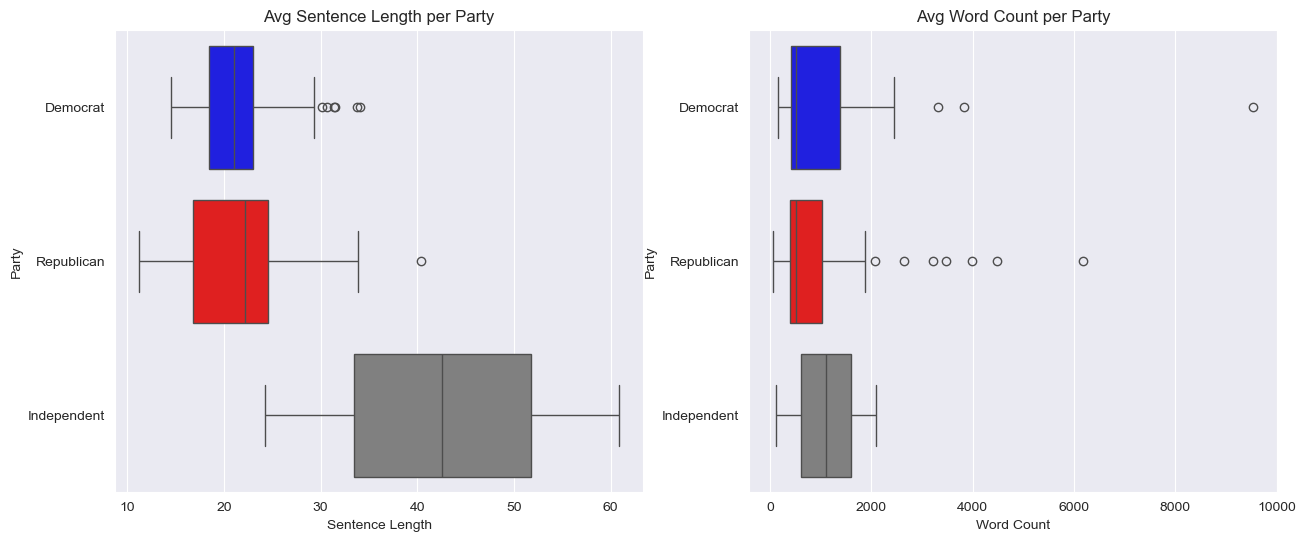

In [24]:
party_colors = {'Democrat': 'blue', 'Republican': 'red', 'Independent': 'grey'}
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax = ax.flatten()

sns.boxplot(avg_per_pol, y='party', x='avg_sentence_length', palette=party_colors, ax=ax[0])
ax[0].set_title('Avg Sentence Length per Party')
ax[0].set_xlabel('Sentence Length')
ax[0].set_ylabel('Party')

sns.boxplot(avg_per_pol, y='party', x='word_count', palette=party_colors, ax=ax[1])
ax[1].set_title('Avg Word Count per Party')
ax[1].set_xlabel('Word Count')
ax[1].set_ylabel('Party')


In [ ]:
from scipy import stats

avg_per_pol_filtered = avg_per_pol[avg_per_pol['party'].isin(['Republican', 'Democrat'])]
rep_asl = avg_per_pol_filtered[avg_per_pol_filtered['party'] == 'Republican']['avg_sentence_length']
dem_asl = avg_per_pol_filtered[avg_per_pol_filtered['party'] == 'Democrat']['avg_sentence_length']
t_stat_asl, p_value_asl = stats.ttest_ind(rep_asl, dem_asl)

print("=" * 50)
print("AVERAGE SENTENCE LENGTH: Republican vs Democrat")
print("=" * 50)
print(f"Republican mean: {rep_asl.mean():.2f} (SD: {rep_asl.std():.2f})")
print(f"Democrat mean: {dem_asl.mean():.2f} (SD: {dem_asl.std():.2f})")
print(f"T-statistic: {t_stat_asl:.4f}")
print(f"P-value: {p_value_asl:.4f}")
print(f"Significant difference: {'Yes (p < 0.05)' if p_value_asl < 0.05 else 'No (p >= 0.05)'}\n")

AVERAGE SENTENCE LENGTH: Republican vs Democrat
Republican mean: 21.62 (SD: 6.01)
Democrat mean: 21.90 (SD: 5.04)
T-statistic: -0.2456
P-value: 0.8065
Significant difference: No (p >= 0.05)



In [125]:
rep_wc = avg_per_pol_filtered[avg_per_pol_filtered['party'] == 'Republican']['word_count']
dem_wc = avg_per_pol_filtered[avg_per_pol_filtered['party'] == 'Democrat']['word_count']
t_stat_wc, p_value_wc = stats.ttest_ind(rep_wc, dem_wc)

print("=" * 50)
print("WORD COUNT: Republican vs Democrat")
print("=" * 50)
print(f"Republican mean: {rep_wc.mean():.2f} (SD: {rep_wc.std():.2f})")
print(f"Democrat mean: {dem_wc.mean():.2f} (SD: {dem_wc.std():.2f})")
print(f"T-statistic: {t_stat_wc:.4f}")
print(f"P-value: {p_value_wc:.4f}")
print(f"Significant difference: {'Yes (p < 0.05)' if p_value_wc < 0.05 else 'No (p >= 0.05)'}")

WORD COUNT: Republican vs Democrat
Republican mean: 1048.67 (SD: 1228.13)
Democrat mean: 1133.99 (SD: 1525.49)
T-statistic: -0.3033
P-value: 0.7623
Significant difference: No (p >= 0.05)


In [126]:
# Average Word Count per Speech Type
avg_wc_type = df_clean.groupby("type_of_speech")["word_count"].mean().sort_values(ascending=False).reset_index()
avg_wc_type

type_of_speech   word_count
0          senate_floor_speeches  3145.534884
1           house_floor_speeches  2830.377934
2        partisan_rally_speeches   845.036036
3  bipartisan_and_other_speeches   367.335155

/var/folders/3g/dp60lf1j62x6b5x7rrx2m1rc0000gn/T/ipykernel_22313/295811753.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticklabels)


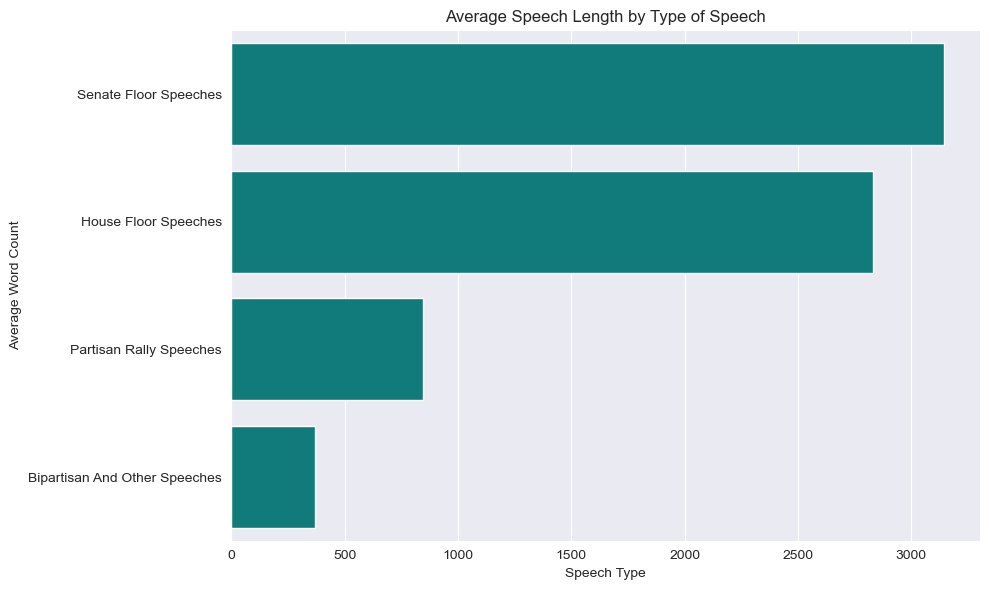

In [128]:
plt.figure(figsize=(10, 6))

ax = sns.barplot(avg_wc_type, x='word_count', y='type_of_speech', color='darkcyan')
plt.title("Average Speech Length by Type of Speech")
plt.ylabel("Average Word Count")
plt.xlabel("Speech Type")

yticklabels = [label.get_text().replace('_', ' ').title() for label in ax.get_yticklabels()]
ax.set_yticklabels(yticklabels)
plt.tight_layout()
plt.show()


/var/folders/3g/dp60lf1j62x6b5x7rrx2m1rc0000gn/T/ipykernel_22313/1978607661.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=df_clean, y="type_of_speech", x="word_count", palette="Set3")
/var/folders/3g/dp60lf1j62x6b5x7rrx2m1rc0000gn/T/ipykernel_22313/1978607661.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticklabels)


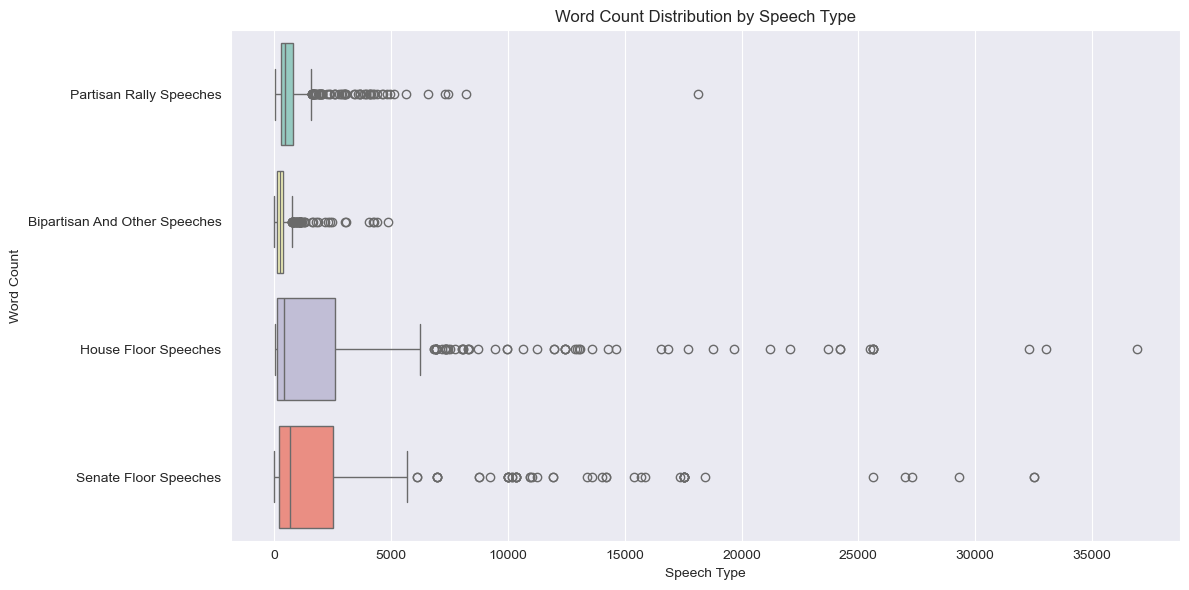

In [130]:
# Boxplot of Word Count by Speech Type

plt.figure(figsize=(12, 6))
ax = sns.boxplot(data=df_clean, y="type_of_speech", x="word_count", palette="Set3")
plt.title("Word Count Distribution by Speech Type")
plt.xlabel("Speech Type")
plt.ylabel("Word Count")

yticklabels = [label.get_text().replace('_', ' ').title() for label in ax.get_yticklabels()]
ax.set_yticklabels(yticklabels)
plt.tight_layout()
plt.show()

# SECTION 3: Clustering Analysis (By Party and By Speech Type)

## 3.1. Speech-level Clustering

In [8]:
from sklearn.preprocessing import StandardScaler

features = ["sadness", "joy", "love", "anger", "fear", "surprise"]
df_features = df_clean[features].copy()

scaler = StandardScaler()
X = scaler.fit_transform(df_features)

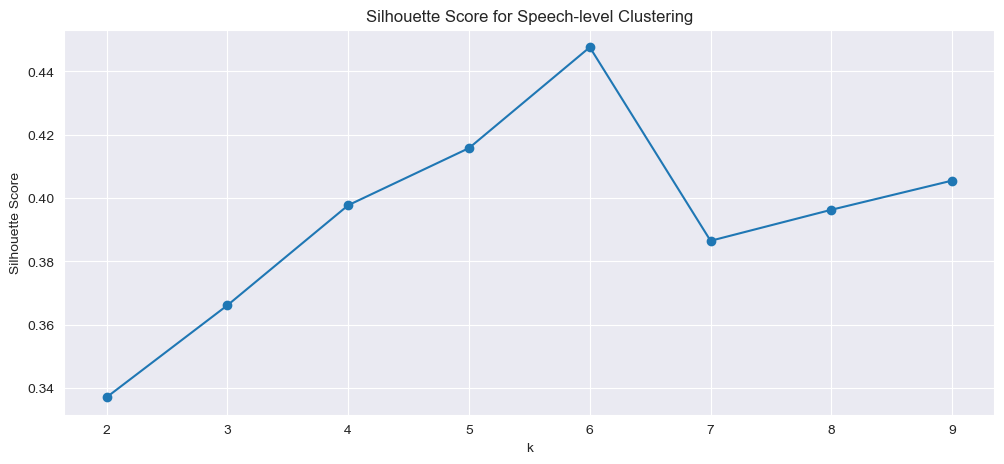

In [10]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
sil_scores = []

for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X)
    sil = silhouette_score(X, labels)
    sil_scores.append(sil)

plt.figure(figsize=(12,5))
plt.plot(range(2,10), sil_scores, marker="o")
plt.title("Silhouette Score for Speech-level Clustering")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.show()

In [ ]:
# Fit Final Politician Clustering Model
k_speech = 4
km_speech = KMeans(n_clusters=k_speech, random_state=42)
df_clean["speech_cluster"] = km_speech.fit_predict(X)

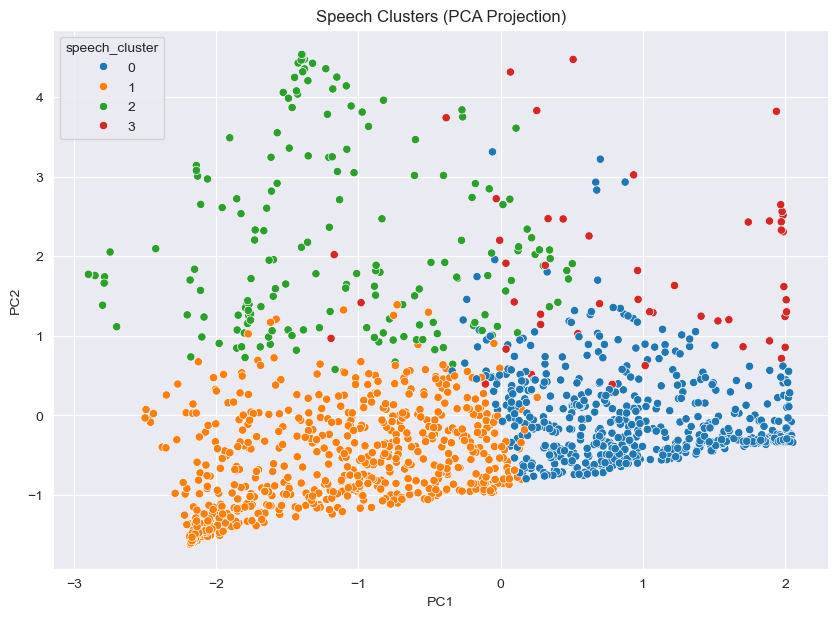

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=X_pca[:,0],
    y=X_pca[:,1],
    hue=df_clean["speech_cluster"],
    palette="tab10"
)
plt.title("Speech Clusters (PCA Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()



In [16]:
loadings = pca.components_
loadings_df = pd.DataFrame(
    loadings.T, 
    columns=['PC1', 'PC2'],
    index=features
)

loadings_df

PC1       PC2
sadness  -0.215814  0.756533
joy       0.706271 -0.125126
love      0.117009  0.310598
anger    -0.587204 -0.471718
fear     -0.309902  0.192911
surprise -0.008087  0.236218

In [19]:
print(f"PC1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"PC2: {pca.explained_variance_ratio_[1]:.2%}")
print(f"Total: {pca.explained_variance_ratio_.sum():.2%}")

PC1: 31.96%
PC2: 19.12%
Total: 51.08%


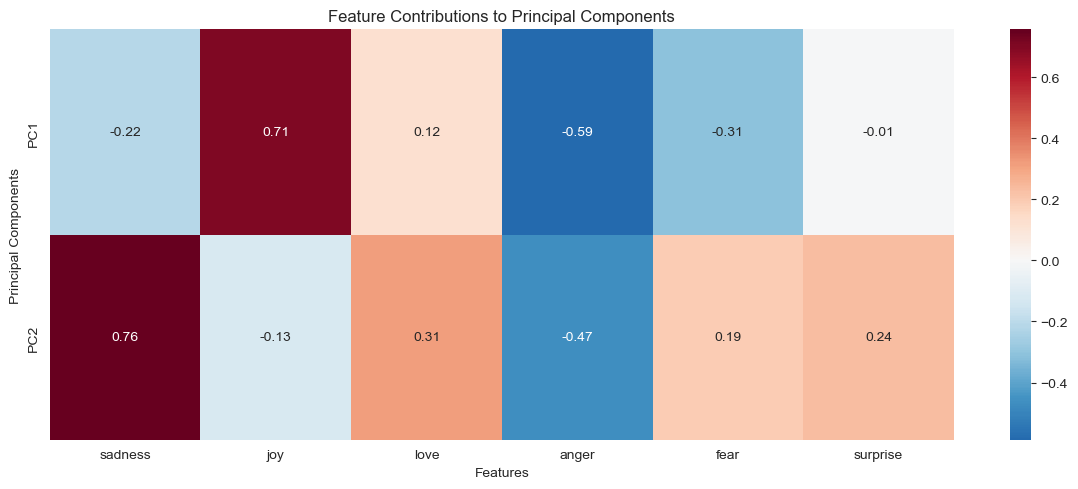

In [20]:
# Heatmap of loadings
plt.figure(figsize=(12, 5))
sns.heatmap(loadings_df.T, cmap='RdBu_r', center=0, annot=True, fmt='.2f')
plt.title("Feature Contributions to Principal Components")
plt.xlabel("Features")
plt.ylabel("Principal Components")
plt.tight_layout()
plt.show()

In [22]:
df_clean['speech_cluster'] = df_clean['speech_cluster'].astype(str)
pd.crosstab(
    df_clean['speech_cluster'], 
    df_clean['type_of_speech'],
    margins=True
)

type_of_speech  bipartisan_and_other_speeches  house_floor_speeches  \
speech_cluster                                                        
0                                         272                   164   
1                                         231                   190   
2                                          43                    58   
3                                           3                    14   
All                                       549                   426   

type_of_speech  partisan_rally_speeches  senate_floor_speeches   All  
speech_cluster                                                        
0                                   315                     87   838  
1                                   145                    181   747  
2                                    63                     27   191  
3                                    32                      6    55  
All                                 555                    301  1831

In [23]:
pd.crosstab(
    df_clean['speech_cluster'], 
    df_clean['party'],
    margins=True
)

party           Democrat  Independent  Republican   All
speech_cluster                                         
0                    346           28         440   814
1                    335           21         355   711
2                     98            8          79   185
3                     26            0          27    53
All                  805           57         901  1763

In [24]:
pd.crosstab(
    df_clean['speech_cluster'], 
    df_clean['type_of_speech'],
    normalize='index'
) * 100

type_of_speech  bipartisan_and_other_speeches  house_floor_speeches  \
speech_cluster                                                        
0                                   32.458234             19.570406   
1                                   30.923695             25.435074   
2                                   22.513089             30.366492   
3                                    5.454545             25.454545   

type_of_speech  partisan_rally_speeches  senate_floor_speeches  
speech_cluster                                                  
0                             37.589499              10.381862  
1                             19.410977              24.230254  
2                             32.984293              14.136126  
3                             58.181818              10.909091

## 3.2. Politician-level Clustering

In [27]:
politician_emotions = df_clean.groupby('politician_standardized')[features].mean()
politician_party = df_clean.groupby('politician_standardized')['party'].first()
politician_emotions['party'] = politician_party

X_politicians = politician_emotions[features]
scaler = StandardScaler()
X_politicians_scaled = scaler.fit_transform(X_politicians)

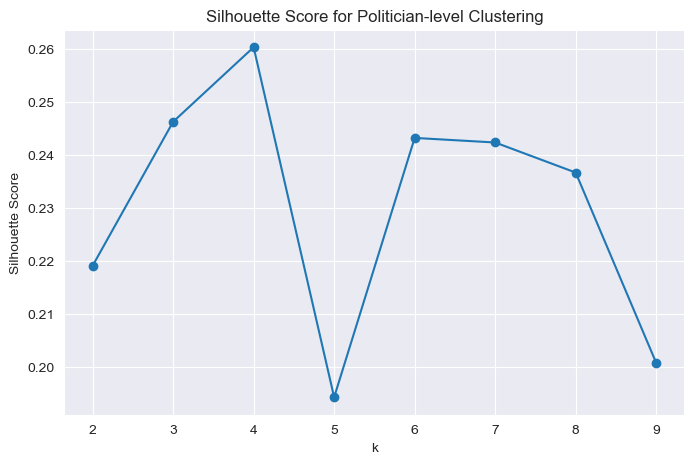

In [28]:
sil_scores = []
for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_politicians_scaled)
    sil = silhouette_score(X_politicians_scaled, labels)
    sil_scores.append(sil)

plt.figure(figsize=(8, 5))
plt.plot(range(2, 10), sil_scores, marker='o')
plt.title("Silhouette Score for Politician-level Clustering")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.show()

In [31]:
optimal_k = 4
km = KMeans(n_clusters=optimal_k, random_state=42)
politician_emotions['politician_cluster'] = km.fit_predict(X_politicians_scaled)

In [34]:
politician_emotions.groupby(['politician_cluster', 'party']).size().reset_index(name='count')

politician_cluster        party  count
0                   0     Democrat     17
1                   0  Independent      1
2                   0   Republican      7
3                   1     Democrat     23
4                   1  Independent      1
5                   1   Republican     37
6                   2     Democrat      5
7                   2   Republican      6
8                   3   Republican      1

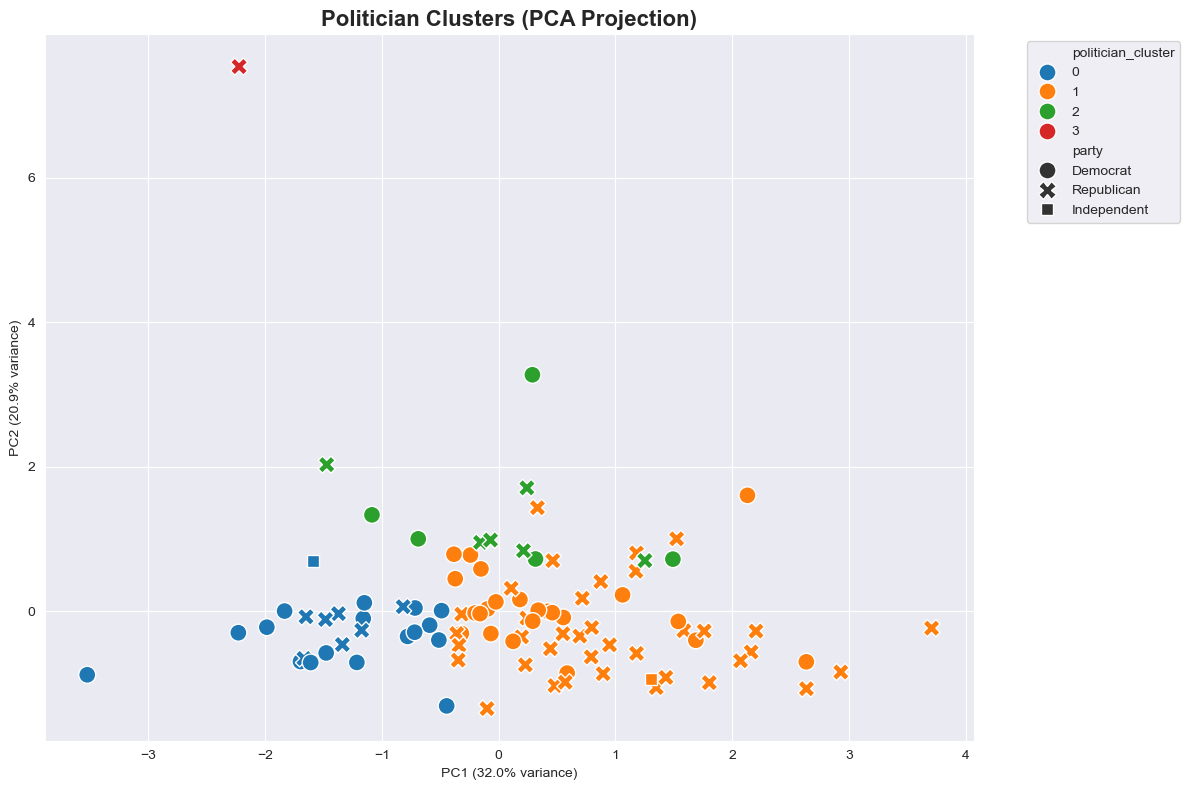

In [35]:
pca_pol = PCA(n_components=2)
X_pca_pol = pca_pol.fit_transform(X_politicians_scaled)
politician_emotions['PC1'] = X_pca_pol[:, 0]
politician_emotions['PC2'] = X_pca_pol[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=politician_emotions,
    x='PC1',
    y='PC2',
    hue='politician_cluster',
    style='party',
    s=150,
    palette='tab10'
)
plt.title("Politician Clusters (PCA Projection)", fontsize=16, fontweight='bold')
plt.xlabel(f"PC1 ({pca_pol.explained_variance_ratio_[0]:.1%} variance)")
plt.ylabel(f"PC2 ({pca_pol.explained_variance_ratio_[1]:.1%} variance)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [37]:
loadings_pol = pd.DataFrame(
    pca_pol.components_.T,
    columns=['PC1', 'PC2'],
    index=features
)
loadings_pol

PC1       PC2
sadness  -0.109503  0.766117
joy       0.667233 -0.212885
love      0.335989 -0.054272
anger    -0.615587 -0.394535
fear     -0.209831  0.163432
surprise  0.083333  0.427120

# SECTION 4: Party-Based and Speech-Type-Based Analysis

This section examines how speeches differ across political parties and across types of speech.
The goal is to identify systematic rhetorical patterns, including tonal choices, topic emphasis, and stylistic tendencies that separate Democrats, Republicans, and Independents, as well as partisan versus bipartisan versus procedural speeches.

We focus on three major dimensions:

* Emotional tone

* Topic distributions

* Linguistic characteristics (sentence length and word count)

## 4.1. Emotional Tone by Party

In [38]:
emotion_cols = ["anger", "joy", "sadness", "fear", "love", "surprise"]
party_emotions = df_clean.groupby("party")[emotion_cols].mean()
party_emotions

anger       joy   sadness      fear      love  surprise
party                                                                  
Democrat     0.343564  0.456725  0.108966  0.064657  0.020015  0.006074
Independent  0.320637  0.493766  0.118780  0.048475  0.013137  0.005205
Republican   0.312683  0.516132  0.087052  0.057171  0.018324  0.008638

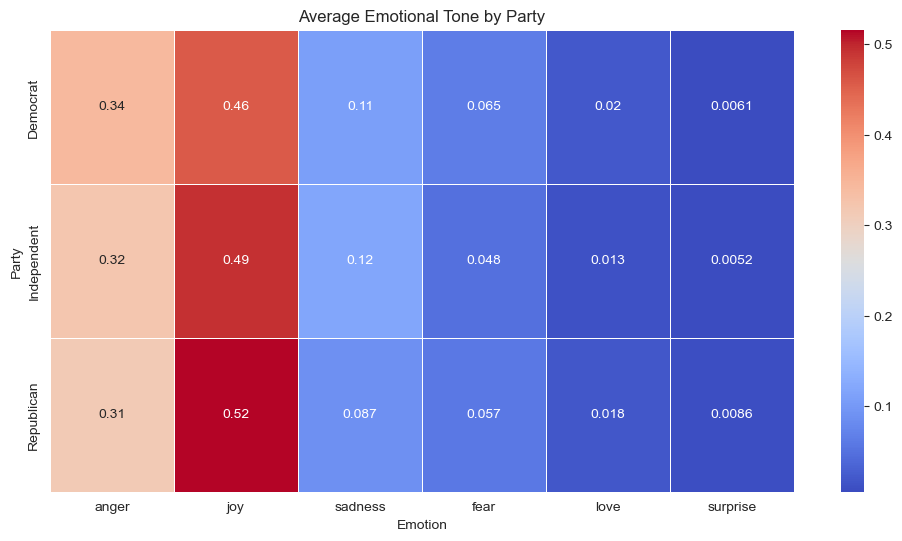

In [39]:
plt.figure(figsize=(12, 6))
sns.heatmap(party_emotions, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Average Emotional Tone by Party")
plt.xlabel("Emotion")
plt.ylabel("Party")
plt.show()


## 4.2 Comparing Speech Types Across Parties

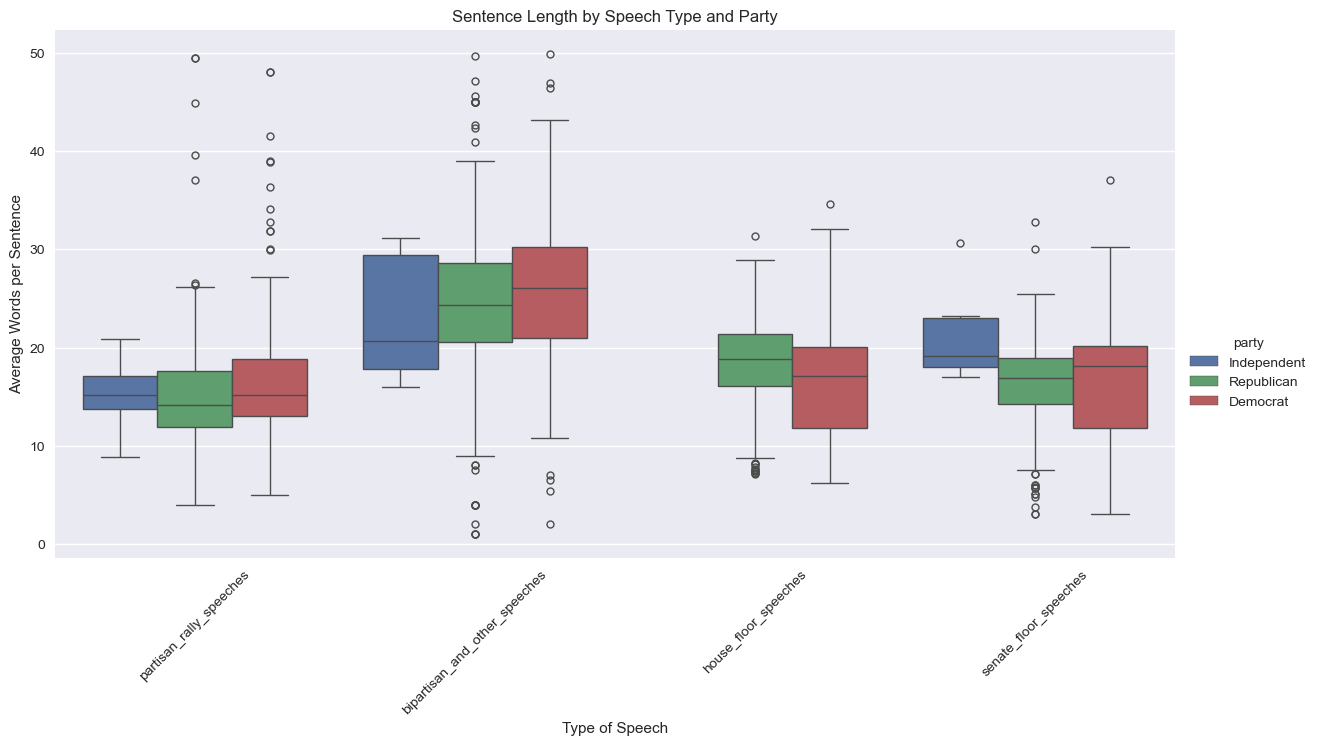

In [ ]:
sns.catplot(
    data=df_clean, 
    x="type_of_speech", 
    y="avg_sentence_length", 
    hue="party",
    kind="box",
    height=6,
    aspect=2
)
plt.title("Sentence Length by Speech Type and Party")
plt.xlabel("Type of Speech")
plt.ylabel("Average Words per Sentence")
plt.xticks(rotation=45)
plt.show()


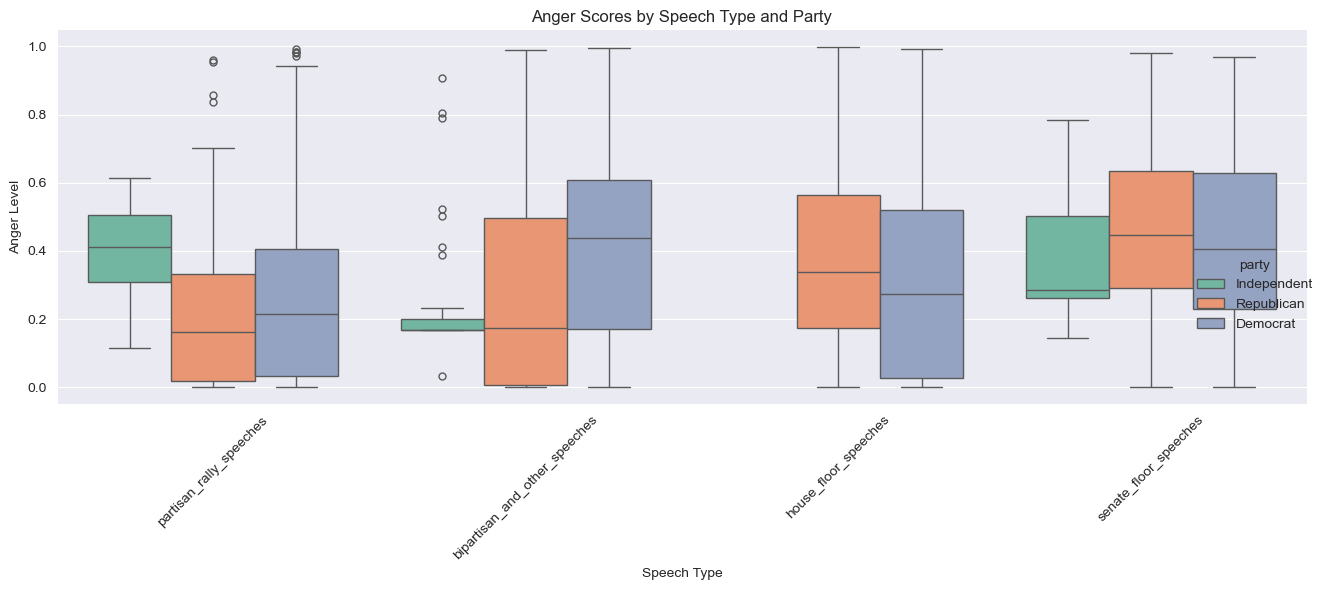

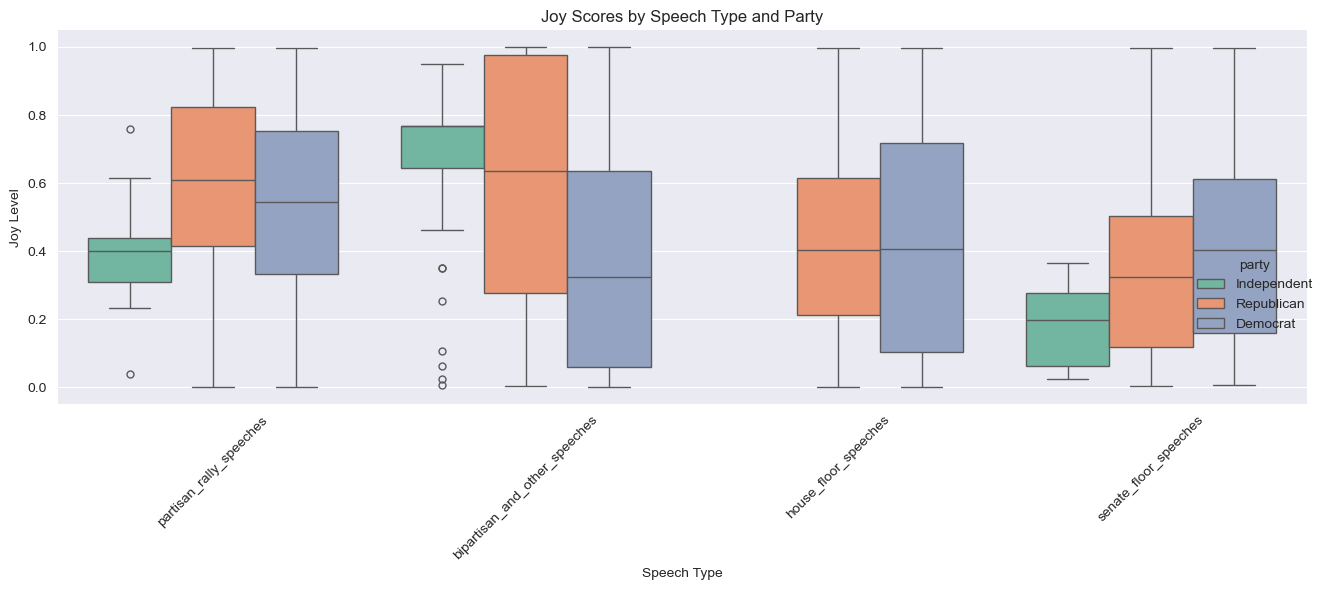

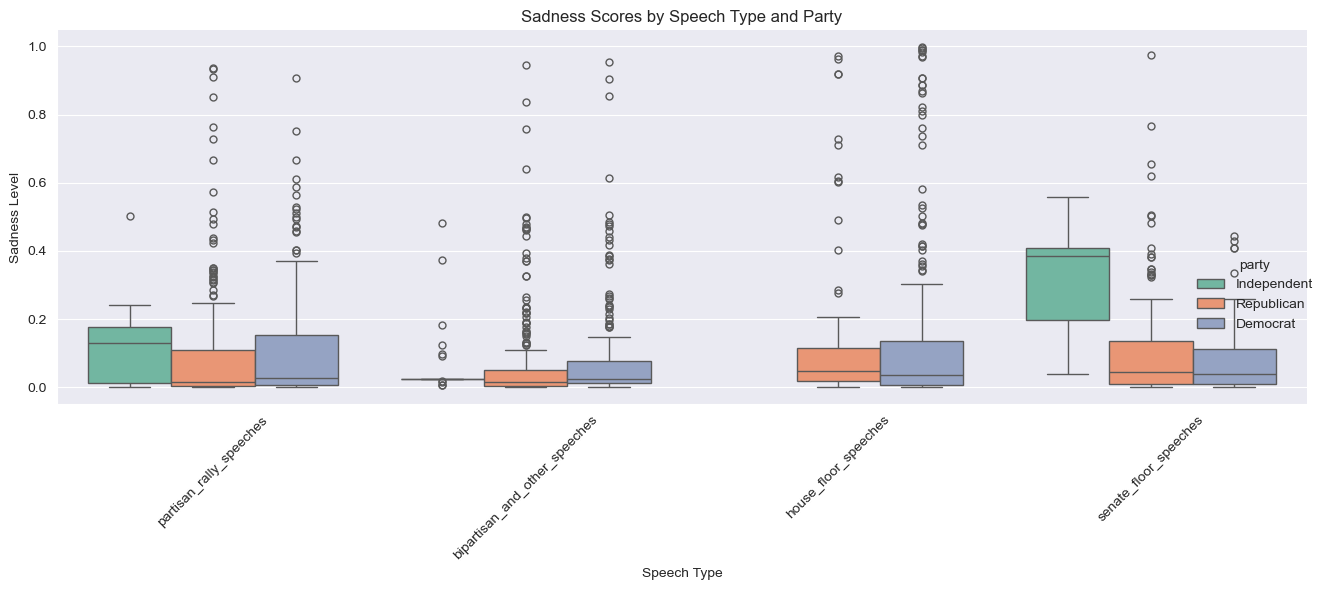

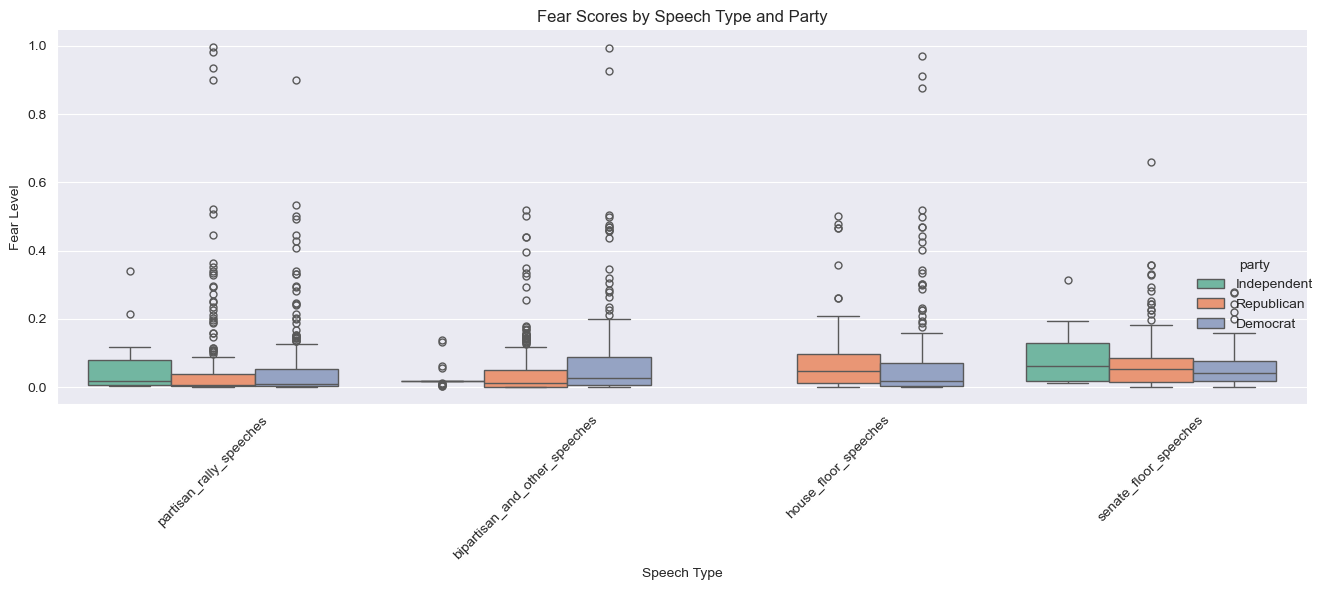

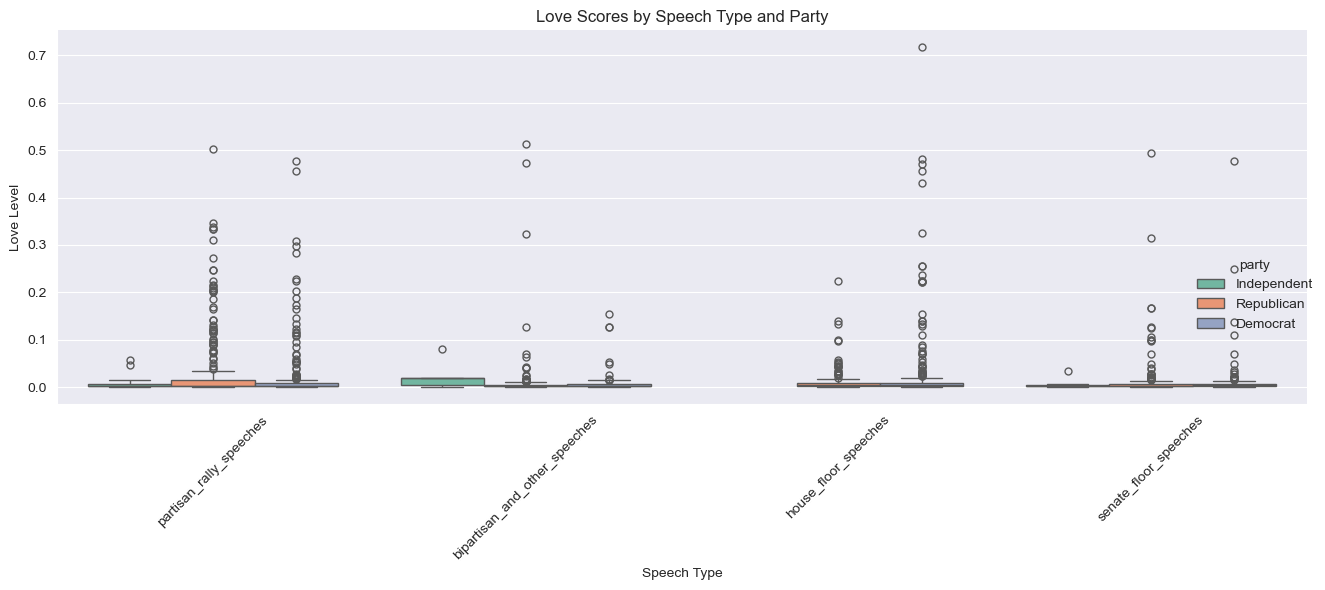

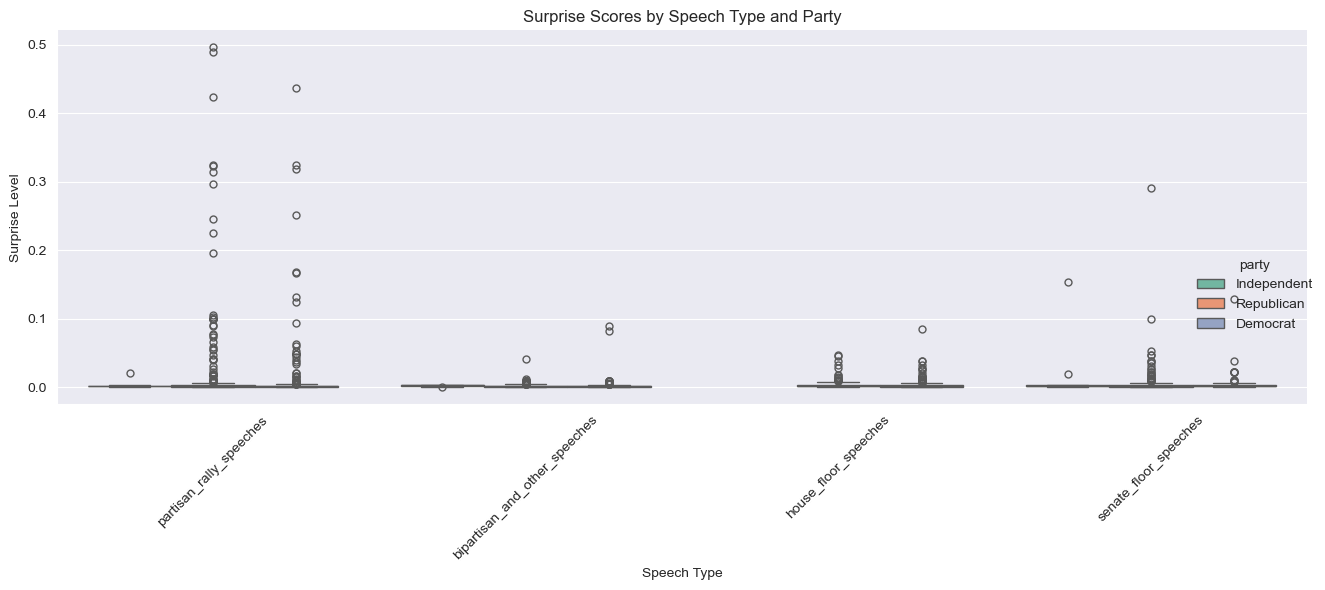

In [41]:
# And for emotional tone
def plot_emotions_by_speech_type(df, emotion_list=emotion_cols):
    """
    Creates boxplots of emotion scores across speech type,
    grouped by party, one plot per emotion.
    """
    for emo in emotion_list:
        g = sns.catplot(
            data=df,
            x="type_of_speech",
            y=emo,
            hue="party",
            kind="box",
            height=6,
            aspect=2,
            palette="Set2"
        )
        plt.title(f"{emo.capitalize()} Scores by Speech Type and Party")
        plt.xlabel("Speech Type")
        plt.ylabel(f"{emo.capitalize()} Level")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

plot_emotions_by_speech_type(df_clean)


# Section 5: Time Series Analysis

This section explores how the emotional content of political speeches changes over time.
By incorporating year, party affiliation, and type of speech, we examine whether rhetorical patterns shift in response to political cycles, elections, crises, and changes in leadership.

Our guiding questions:

1. How do emotional tones evolve from 2016 to 2025?

2. Do parties differ in their emotional trajectories?

3. Do certain types of speeches (rallies, bipartisan remarks, floor speeches) show distinct emotional patterns over time?

In [25]:
df_clean["year"].value_counts().sort_index()

year
2010.0      2
2012.0      7
2013.0      2
2014.0      4
2015.0      1
2016.0    306
2017.0     56
2018.0     32
2019.0     25
2020.0     51
2021.0     52
2022.0     34
2023.0     46
2024.0    240
2025.0    255
Name: count, dtype: int64

In [26]:
# Average Emotion Per Year
df_time = df_clean[df_clean["year"] >= 2016].copy()
emotion_cols = ["anger", "joy", "sadness", "fear", "love", "surprise"]

yearly_emotions = (
    df_time.groupby("year")[emotion_cols]
           .mean().round(4)
           .reset_index()
)
yearly_emotions

year   anger     joy  sadness    fear    love  surprise
0  2016.0  0.3006  0.4958   0.1070  0.0655  0.0233    0.0077
1  2017.0  0.3700  0.3896   0.1483  0.0657  0.0157    0.0107
2  2018.0  0.3028  0.5405   0.0798  0.0445  0.0250    0.0074
3  2019.0  0.3725  0.4338   0.0620  0.0775  0.0434    0.0108
4  2020.0  0.3294  0.4588   0.1248  0.0680  0.0137    0.0053
5  2021.0  0.4934  0.3035   0.1229  0.0591  0.0148    0.0062
6  2022.0  0.2862  0.5107   0.1316  0.0474  0.0168    0.0073
7  2023.0  0.5018  0.3695   0.0462  0.0674  0.0076    0.0075
8  2024.0  0.3709  0.4133   0.1212  0.0672  0.0219    0.0054
9  2025.0  0.3672  0.4643   0.0951  0.0634  0.0067    0.0033

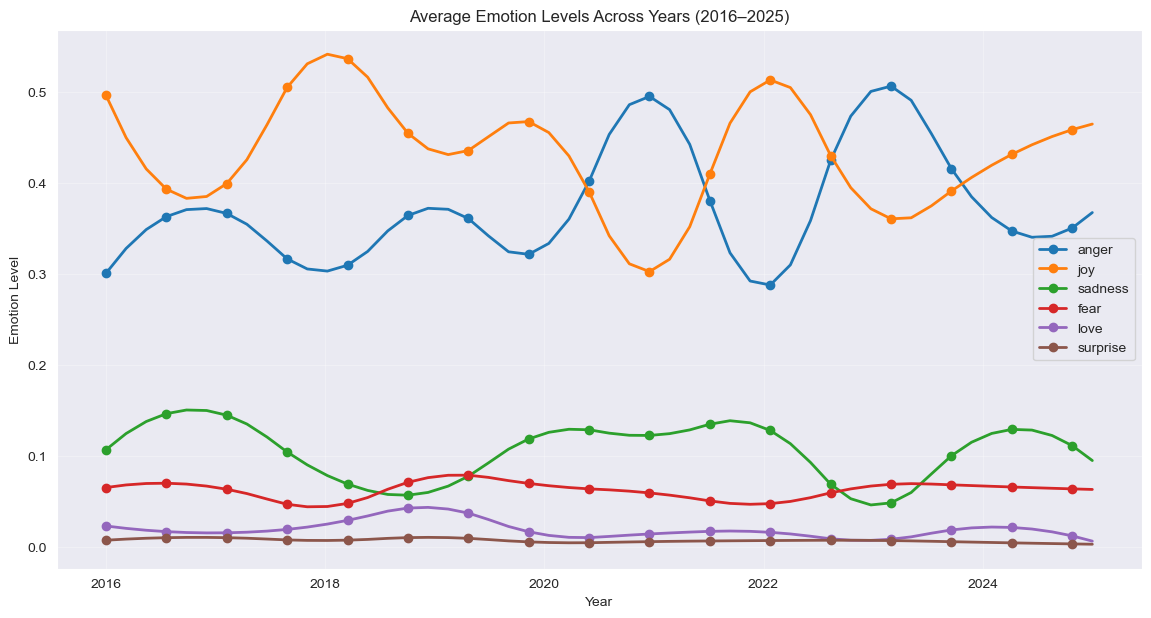

In [29]:
from scipy.interpolate import make_interp_spline
import numpy as np

plt.figure(figsize=(14, 7))

for emo in emotion_cols:
    x = yearly_emotions["year"].values
    y = yearly_emotions[emo].values
    
    x_smooth = np.linspace(x.min(), x.max(), 50)
    spl = make_interp_spline(x, y, k=2)  # k=3 for cubic spline
    y_smooth = spl(x_smooth)
    
    plt.plot(x_smooth, y_smooth, label=emo, linewidth=2, marker='o', markevery=3)

plt.title("Average Emotion Levels Across Years (2016–2025)")
plt.xlabel("Year")
plt.ylabel("Emotion Level")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

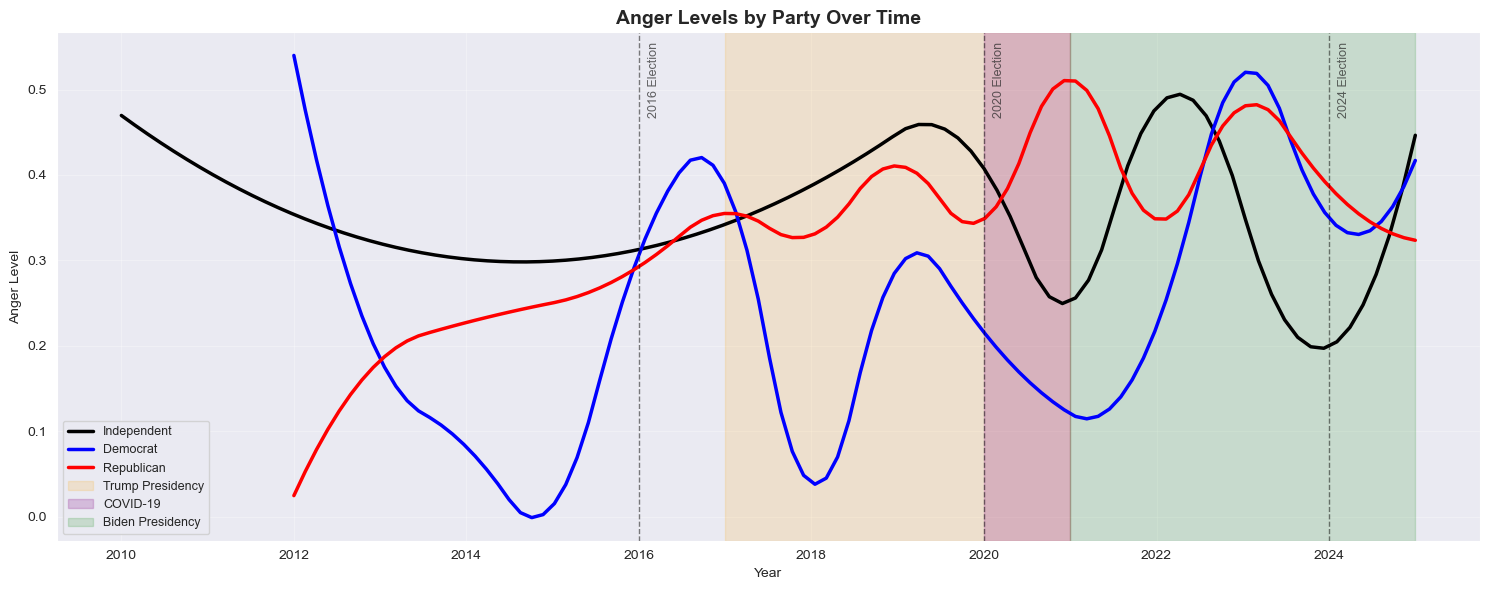

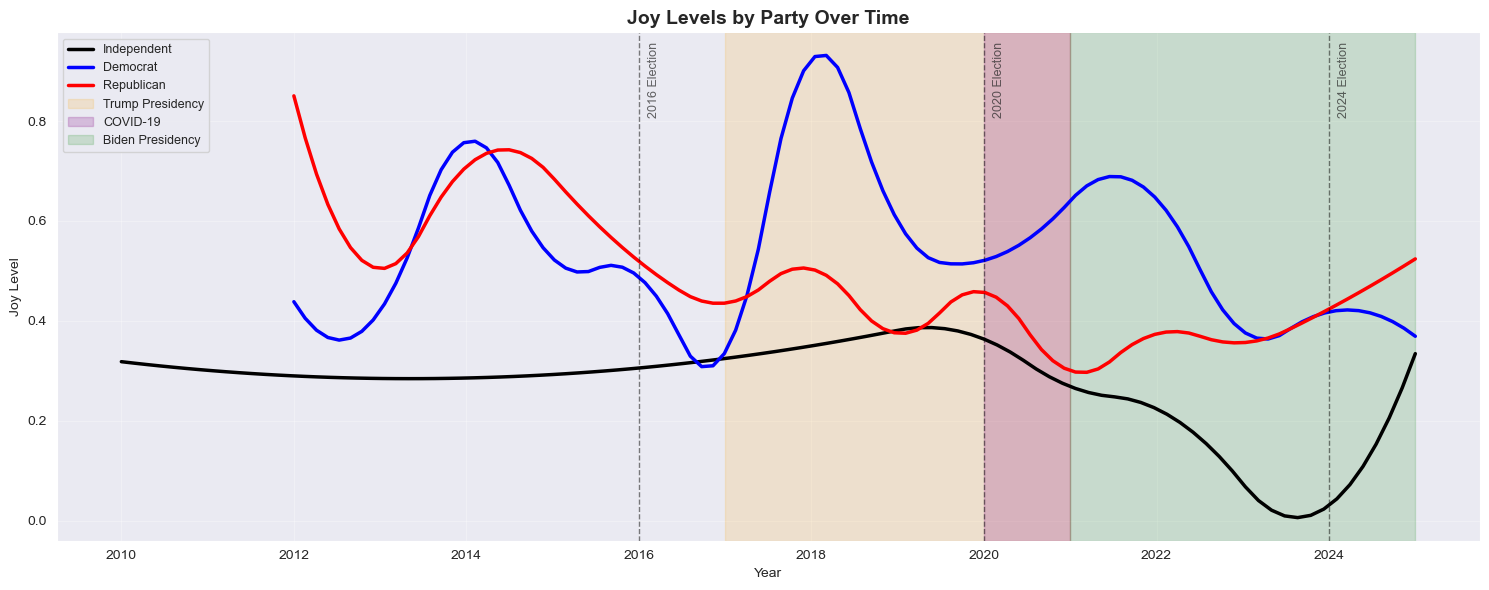

In [32]:
yearly_emotions_party = df_clean.groupby(['year', 'party'])[['anger', 'joy']].mean().reset_index()

party_colors = {'Democrat': 'blue', 'Republican': 'red', 'Independent': 'black'}

# Create separate figures for each emotion
for emotion in ['anger', 'joy']:
    fig, ax = plt.subplots(figsize=(15, 6))
    
    for party in yearly_emotions_party['party'].unique():
        party_data = yearly_emotions_party[yearly_emotions_party['party'] == party]
        x = party_data['year'].values
        y = party_data[emotion].values
        
        if len(x) > 3:
            x_smooth = np.linspace(x.min(), x.max(), 100)
            spl = make_interp_spline(x, y, k=2)
            y_smooth = spl(x_smooth)
            ax.plot(x_smooth, y_smooth, label=party, linewidth=2.5, 
                   color=party_colors.get(party, 'grey'))
        else:
            ax.plot(x, y, label=party, linewidth=2.5, 
                   color=party_colors.get(party, 'grey'))
    
    # Add event spans
    ax.axvspan(2017, 2021, alpha=0.15, color='orange', label='Trump Presidency')
    ax.axvspan(2020, 2021, alpha=0.2, color='purple', label='COVID-19')
    ax.axvspan(2021, 2025, alpha=0.15, color='green', label='Biden Presidency')
    
    # Add vertical lines for key events
    ax.axvline(2016, color='black', linestyle='--', alpha=0.5, linewidth=1)
    ax.text(2016+0.1, ax.get_ylim()[1]*0.98, '2016 Election', 
           rotation=90, verticalalignment='top', fontsize=9, alpha=0.7)
    
    ax.axvline(2020, color='black', linestyle='--', alpha=0.5, linewidth=1)
    ax.text(2020+0.1, ax.get_ylim()[1]*0.98, '2020 Election', 
           rotation=90, verticalalignment='top', fontsize=9, alpha=0.7)
    
    ax.axvline(2024, color='black', linestyle='--', alpha=0.5, linewidth=1)
    ax.text(2024+0.1, ax.get_ylim()[1]*0.98, '2024 Election', 
           rotation=90, verticalalignment='top', fontsize=9, alpha=0.7)
    
    ax.set_title(f'{emotion.title()} Levels by Party Over Time', 
                fontsize=14, fontweight='bold')
    ax.set_xlabel('Year')
    ax.set_ylabel(f'{emotion.title()} Level')
    ax.legend(loc='best', fontsize=9)
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

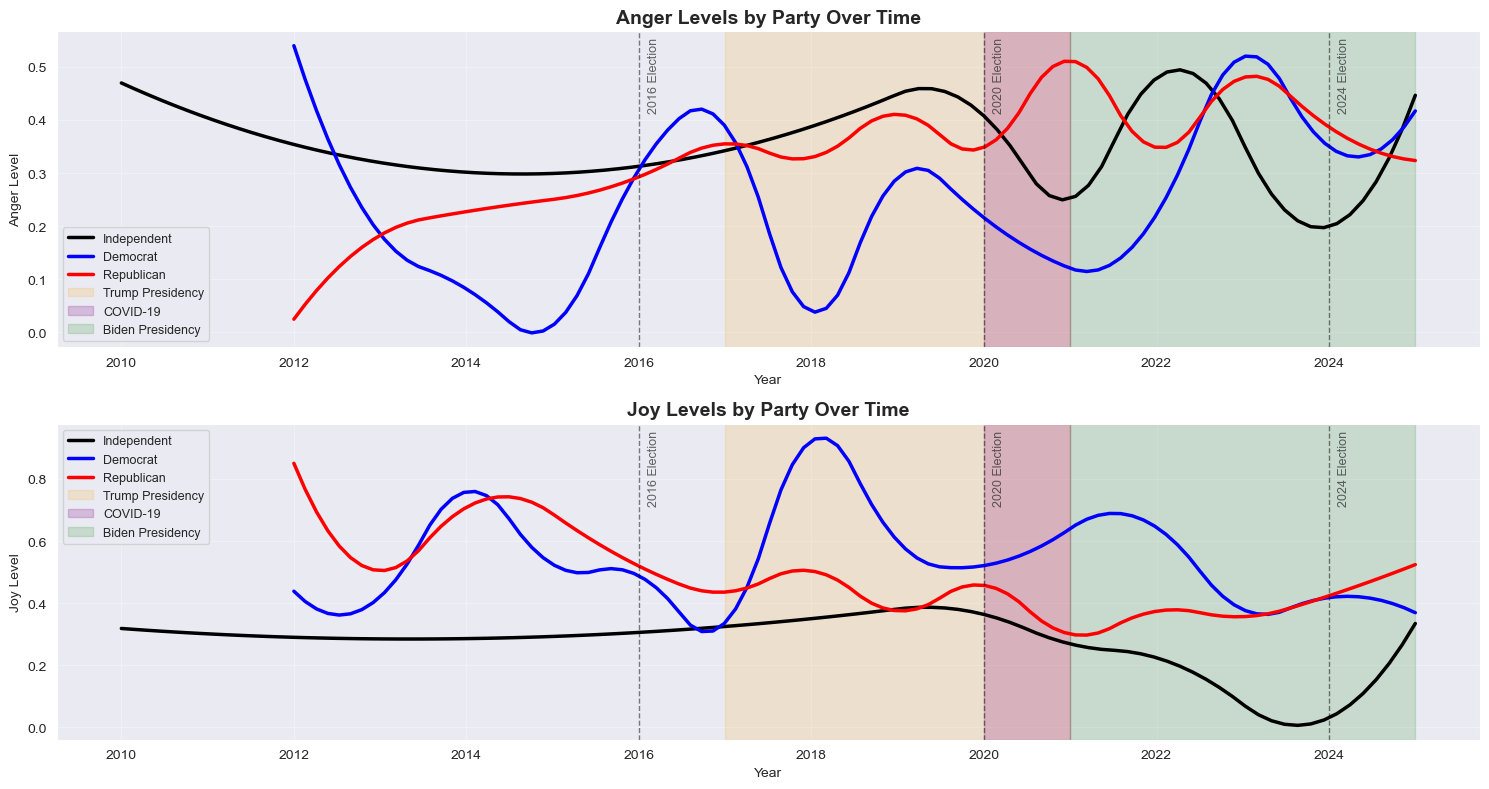

In [31]:
yearly_emotions_party = df_clean.groupby(['year', 'party'])[['anger', 'joy']].mean().reset_index()

fig, axes = plt.subplots(2, 1, figsize=(15, 8))
party_colors = {'Democrat': 'blue', 'Republican': 'red', 'Independent': 'black'}

for ax_idx, emotion in enumerate(['anger', 'joy']):
    for party in yearly_emotions_party['party'].unique():
        party_data = yearly_emotions_party[yearly_emotions_party['party'] == party]
        x = party_data['year'].values
        y = party_data[emotion].values
        
        if len(x) > 3:
            x_smooth = np.linspace(x.min(), x.max(), 100)
            spl = make_interp_spline(x, y, k=2)
            y_smooth = spl(x_smooth)
            axes[ax_idx].plot(x_smooth, y_smooth, label=party, linewidth=2.5, 
                             color=party_colors.get(party, 'grey'))
        else:
            axes[ax_idx].plot(x, y, label=party, linewidth=2.5, 
                             color=party_colors.get(party, 'grey'))
    
    # Add event spans
    axes[ax_idx].axvspan(2017, 2021, alpha=0.15, color='orange', label='Trump Presidency')
    axes[ax_idx].axvspan(2020, 2021, alpha=0.2, color='purple', label='COVID-19')
    axes[ax_idx].axvspan(2021, 2025, alpha=0.15, color='green', label='Biden Presidency')
    
    # Add vertical lines for key events
    axes[ax_idx].axvline(2016, color='black', linestyle='--', alpha=0.5, linewidth=1)
    axes[ax_idx].text(2016+0.1, axes[ax_idx].get_ylim()[1]*0.98, '2016 Election', 
                     rotation=90, verticalalignment='top', fontsize=9, alpha=0.7)
    
    axes[ax_idx].axvline(2020, color='black', linestyle='--', alpha=0.5, linewidth=1)
    axes[ax_idx].text(2020+0.1, axes[ax_idx].get_ylim()[1]*0.98, '2020 Election', 
                     rotation=90, verticalalignment='top', fontsize=9, alpha=0.7)
    
    axes[ax_idx].axvline(2024, color='black', linestyle='--', alpha=0.5, linewidth=1)
    axes[ax_idx].text(2024+0.1, axes[ax_idx].get_ylim()[1]*0.98, '2024 Election', 
                     rotation=90, verticalalignment='top', fontsize=9, alpha=0.7)
    
    axes[ax_idx].set_title(f'{emotion.title()} Levels by Party Over Time', 
                          fontsize=14, fontweight='bold')
    axes[ax_idx].set_xlabel('Year')
    axes[ax_idx].set_ylabel(f'{emotion.title()} Level')
    axes[ax_idx].legend(loc='best', fontsize=9)
    axes[ax_idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

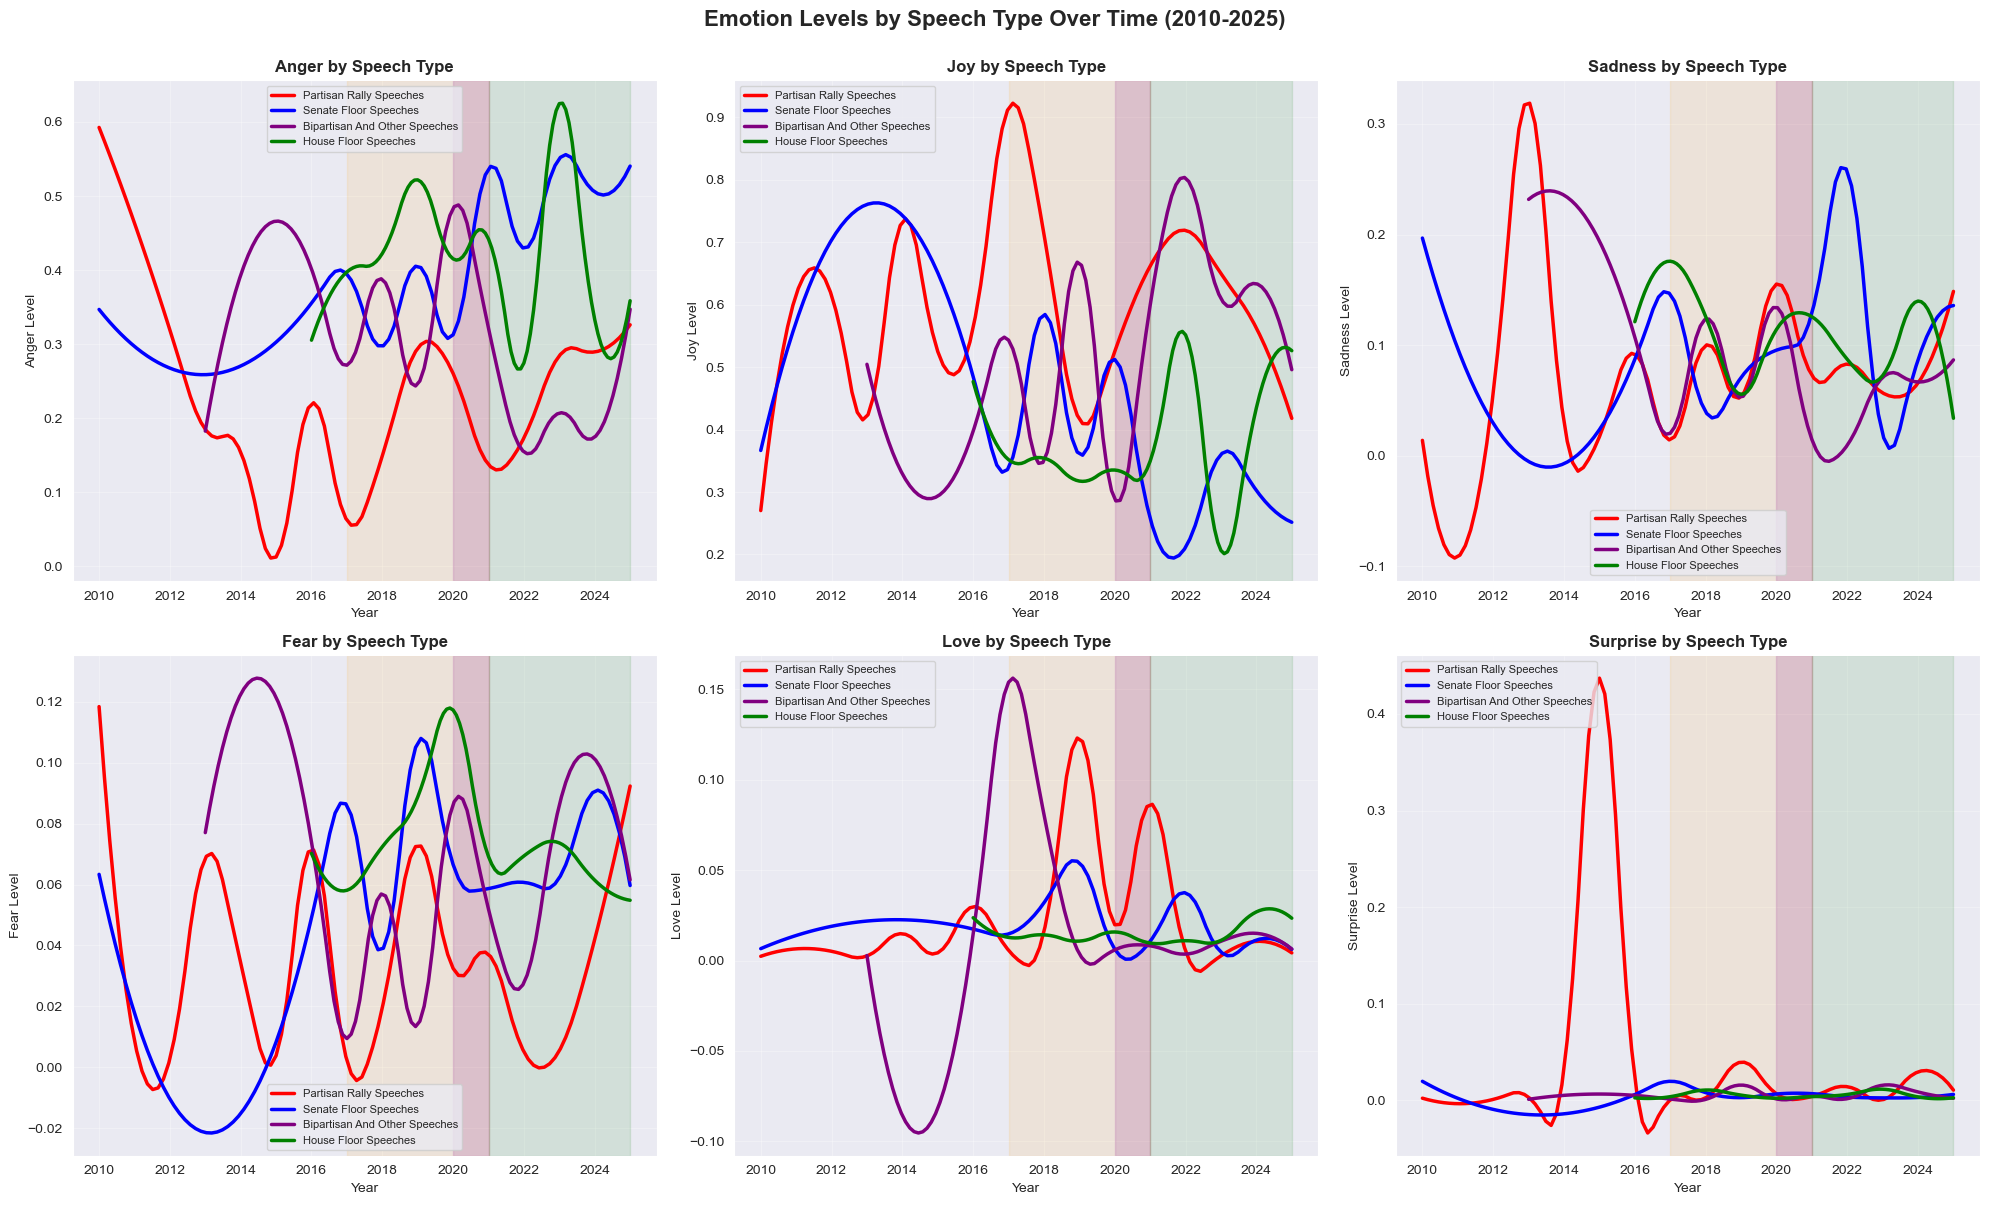

In [78]:
yearly_emotions_type = df_clean.groupby(['year', 'type_of_speech'])[emotion_cols].mean().reset_index()

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

speech_colors = {
    'partisan_rally_speeches': 'red',
    'senate_floor_speeches': 'blue',
    'house_floor_speeches': 'green',
    'bipartisan_and_other_speeches': 'purple'
}

for idx, emotion in enumerate(emotion_cols):
    for speech_type in yearly_emotions_type['type_of_speech'].unique():
        type_data = yearly_emotions_type[yearly_emotions_type['type_of_speech'] == speech_type]
        x = type_data['year'].values
        y = type_data[emotion].values
        
        if len(x) > 3:  # Smooth interpolation
            x_smooth = np.linspace(x.min(), x.max(), 100)
            spl = make_interp_spline(x, y, k=2)
            y_smooth = spl(x_smooth)
            
            label = speech_type.replace('_', ' ').title()
            axes[idx].plot(x_smooth, y_smooth, label=label, linewidth=2.5, 
                          color=speech_colors.get(speech_type, 'gray'))
        else:
            label = speech_type.replace('_', ' ').title()
            axes[idx].plot(x, y, label=label, linewidth=2.5, 
                          color=speech_colors.get(speech_type, 'gray'))
    
    # Add event spans
    axes[idx].axvspan(2017, 2021, alpha=0.1, color='orange')
    axes[idx].axvspan(2020, 2021, alpha=0.15, color='purple')
    axes[idx].axvspan(2021, 2025, alpha=0.1, color='green')
    
    axes[idx].set_title(f'{emotion.title()} by Speech Type', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Year', fontsize=10)
    axes[idx].set_ylabel(f'{emotion.title()} Level', fontsize=10)
    axes[idx].legend(fontsize=8, loc='best')
    axes[idx].grid(alpha=0.3)

plt.suptitle('Emotion Levels by Speech Type Over Time (2010-2025)', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

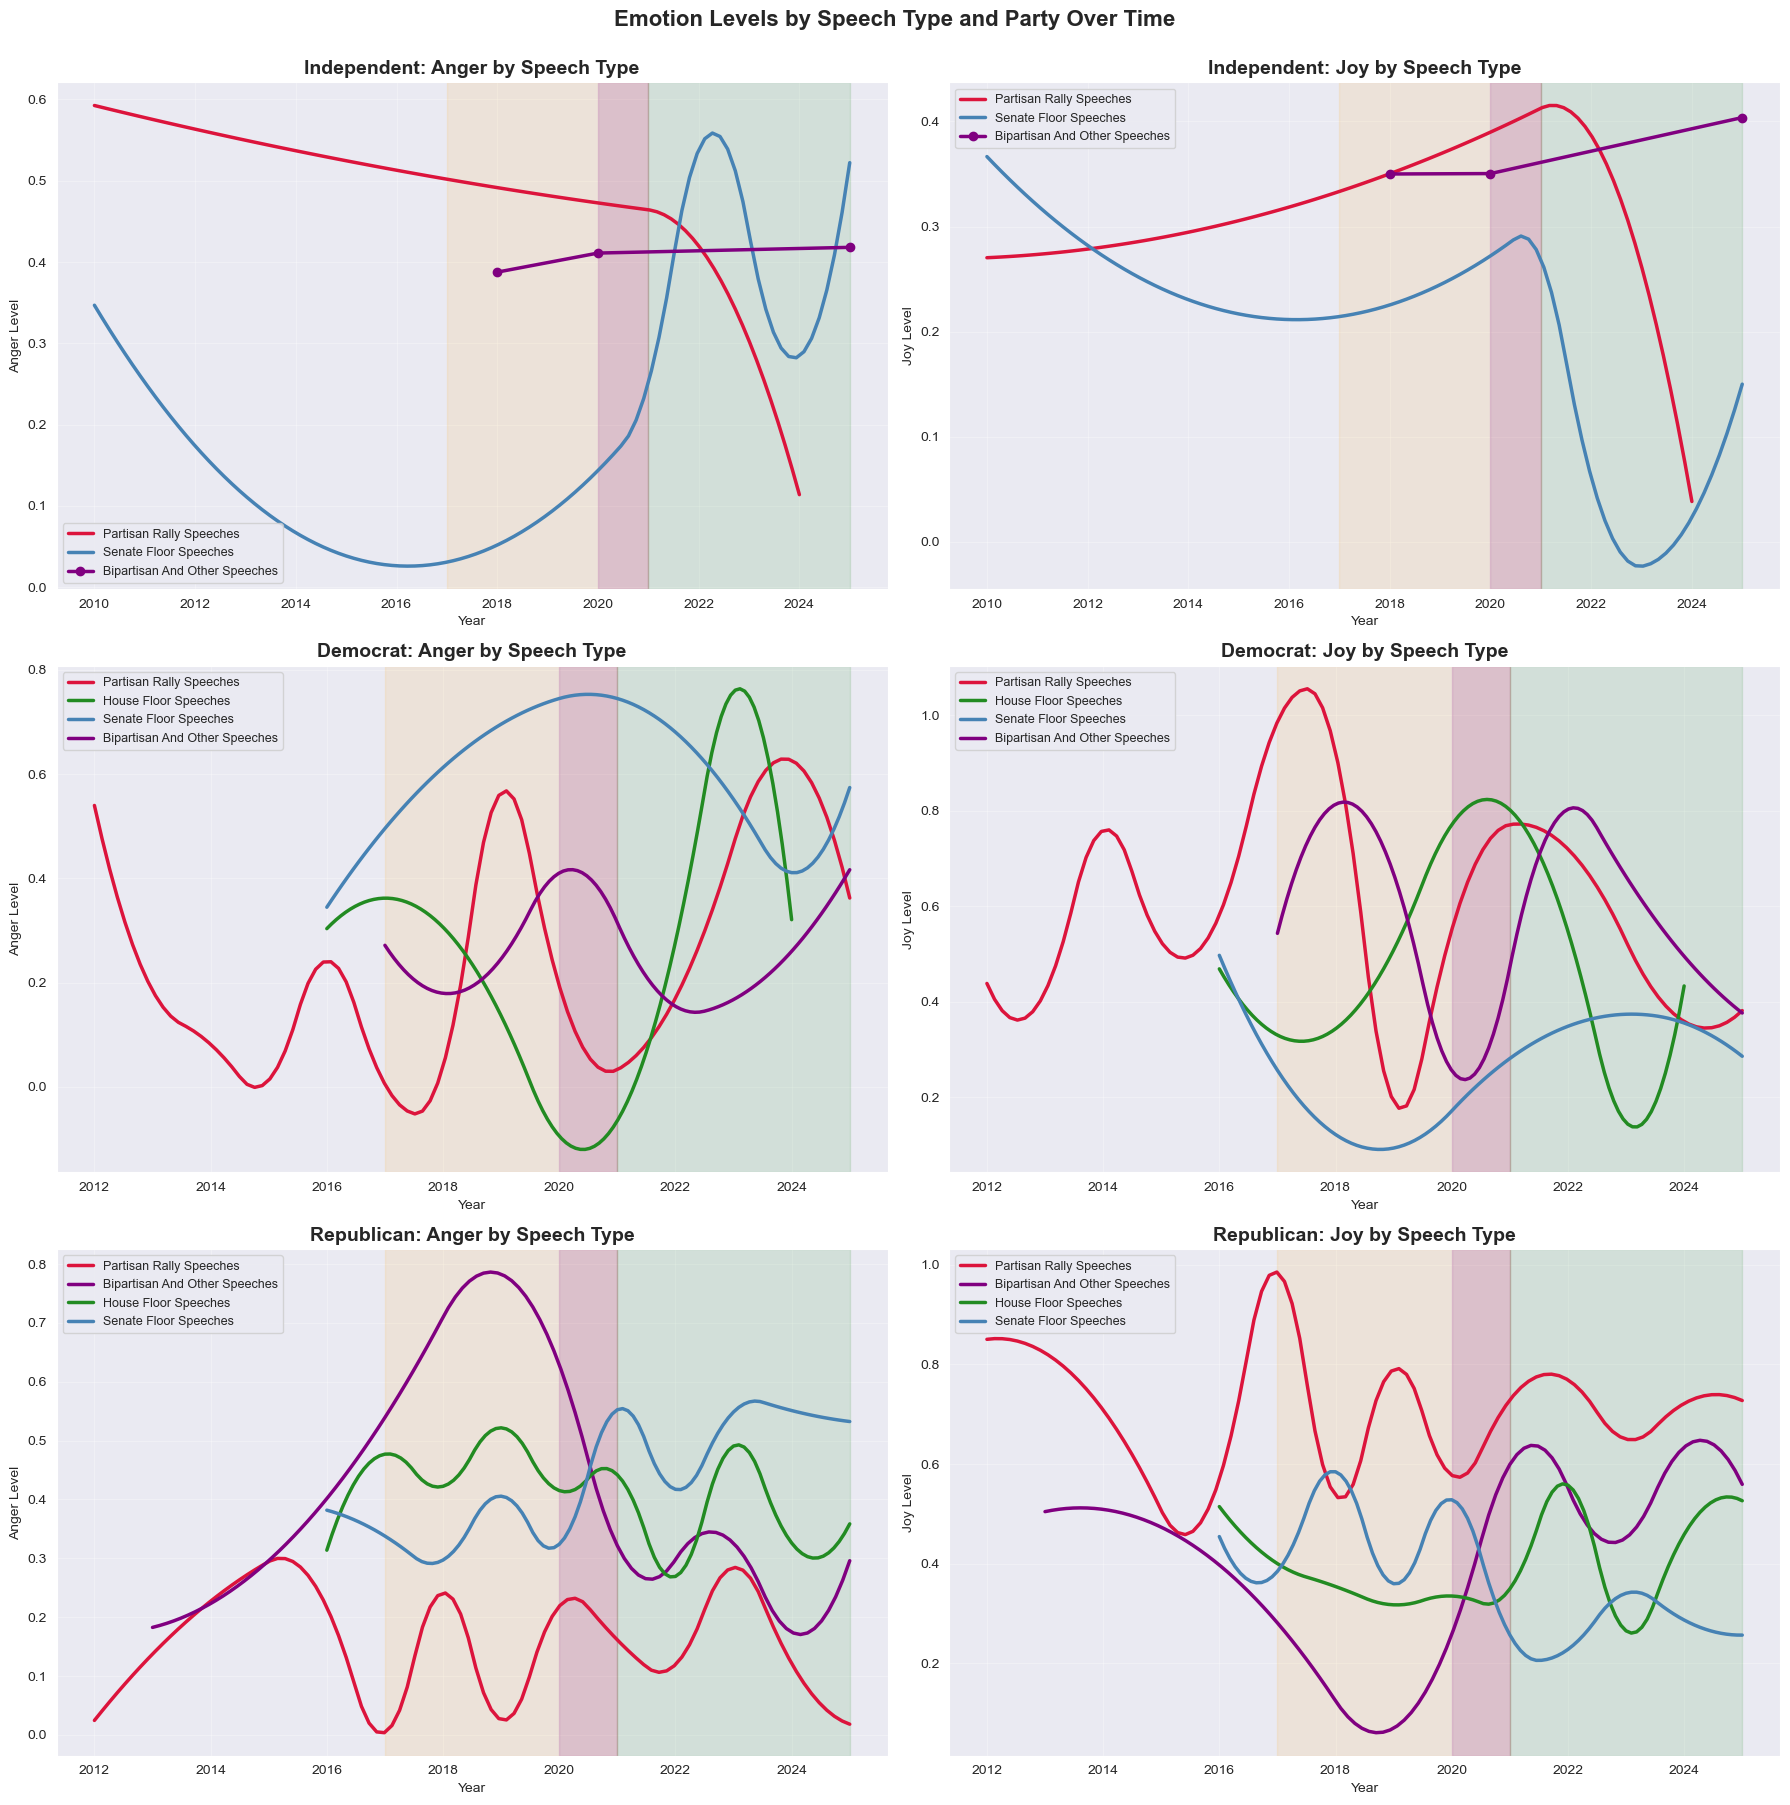

In [79]:
yearly_emotions_party_type = df_clean.groupby(['year', 'party', 'type_of_speech'])[['anger', 'joy']].mean().reset_index()
speech_colors = {
    'partisan_rally_speeches': 'crimson',
    'senate_floor_speeches': 'steelblue',
    'house_floor_speeches': 'forestgreen',
    'bipartisan_and_other_speeches': 'purple'
}

parties = yearly_emotions_party_type['party'].unique()
fig, axes = plt.subplots(len(parties), 2, figsize=(18, 6*len(parties)))

for party_idx, party in enumerate(parties):
    party_data = yearly_emotions_party_type[yearly_emotions_party_type['party'] == party]
    
    for emotion_idx, emotion in enumerate(['anger', 'joy']):
        ax = axes[party_idx, emotion_idx] if len(parties) > 1 else axes[emotion_idx]
        
        # Plot each speech type
        for speech_type in party_data['type_of_speech'].unique():
            type_data = party_data[party_data['type_of_speech'] == speech_type]
            x = type_data['year'].values
            y = type_data[emotion].values
            
            if len(x) > 3:
                x_smooth = np.linspace(x.min(), x.max(), 100)
                spl = make_interp_spline(x, y, k=2)
                y_smooth = spl(x_smooth)
                
                label = speech_type.replace('_', ' ').title()
                ax.plot(x_smooth, y_smooth, label=label, linewidth=2.5, 
                       color=speech_colors.get(speech_type))
            else:
                label = speech_type.replace('_', ' ').title()
                ax.plot(x, y, label=label, linewidth=2.5, marker='o',
                       color=speech_colors.get(speech_type))
        
        # Add event spans
        ax.axvspan(2017, 2021, alpha=0.1, color='orange')
        ax.axvspan(2020, 2021, alpha=0.15, color='purple')
        ax.axvspan(2021, 2025, alpha=0.1, color='green')
        
        ax.set_title(f'{party}: {emotion.title()} by Speech Type', 
                    fontsize=14, fontweight='bold')
        ax.set_xlabel('Year')
        ax.set_ylabel(f'{emotion.title()} Level')
        ax.legend(fontsize=9, loc='best')
        ax.grid(alpha=0.3)

plt.suptitle('Emotion Levels by Speech Type and Party Over Time', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# Politicians Highest Variance

/var/folders/3g/dp60lf1j62x6b5x7rrx2m1rc0000gn/T/ipykernel_30821/750357855.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[emotion_idx].set_xticklabels(axes[emotion_idx].get_xticklabels(), rotation=45, ha='right')
/var/folders/3g/dp60lf1j62x6b5x7rrx2m1rc0000gn/T/ipykernel_30821/750357855.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[emotion_idx].set_xticklabels(axes[emotion_idx].get_xticklabels(), rotation=45, ha='right')
/var/folders/3g/dp60lf1j62x6b5x7rrx2m1rc0000gn/T/ipykernel_30821/750357855.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[emotion_idx].set_xticklabels(axes[emotion_idx].get_xticklabels(), rotation=45, ha='right')


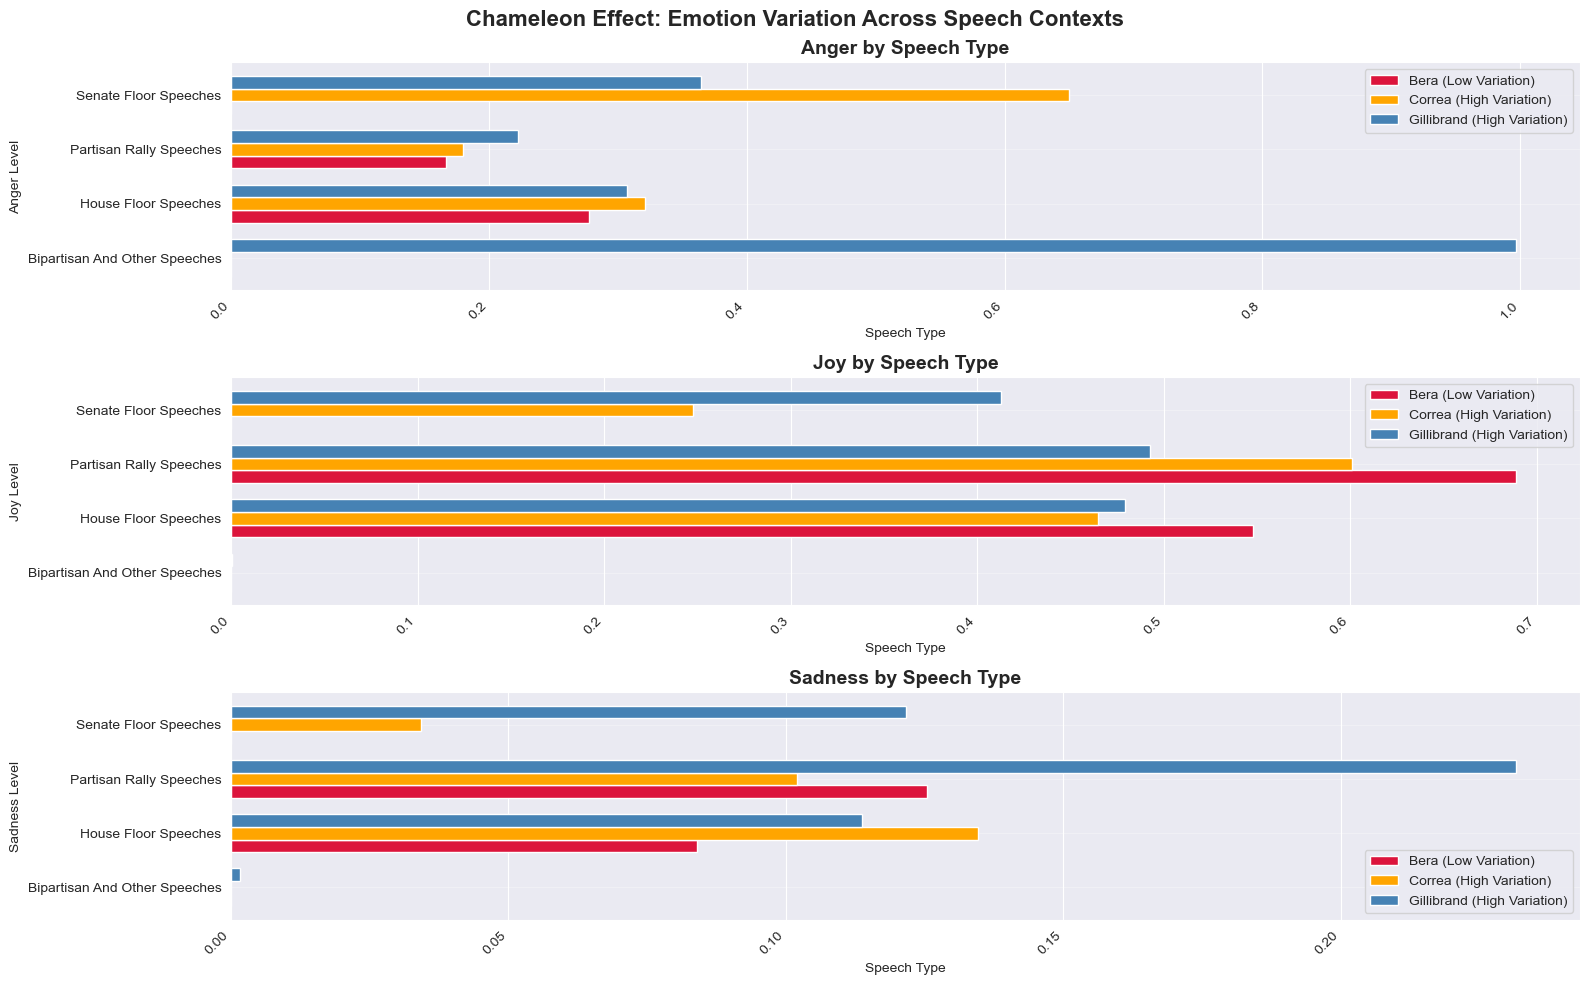

In [94]:
# Instead of time, show variation ACROSS SPEECH TYPES
selected_pols = ['gillibrand_kirsten_e', 'correa_j', 'bera_ami']
type_emotions_pols = df_clean[df_clean['politician_standardized'].isin(selected_pols)].groupby(['type_of_speech', 'politician_standardized'])[['anger', 'joy', 'sadness']].mean().reset_index()

fig, axes = plt.subplots(3, 1, figsize=(16, 10))
axes = axes.flatten()

for emotion_idx, emotion in enumerate(['anger', 'joy', 'sadness']):
    pivot_data = type_emotions_pols.pivot(index='type_of_speech', 
                                          columns='politician_standardized', 
                                          values=emotion)
    pivot_data.columns = [pol_labels[col] for col in pivot_data.columns]
    
    # Clean up speech type names
    pivot_data.index = [name.replace('_', ' ').title() for name in pivot_data.index]
    
    pivot_data.plot(kind='barh', ax=axes[emotion_idx],
                   color=[pol_colors[p] for p in selected_pols],
                   width=0.7)   
    
    axes[emotion_idx].set_title(f'{emotion.title()} by Speech Type', 
                               fontsize=14, fontweight='bold')
    axes[emotion_idx].set_xlabel('Speech Type')
    axes[emotion_idx].set_ylabel(f'{emotion.title()} Level')
    axes[emotion_idx].legend(fontsize=10)
    axes[emotion_idx].set_xticklabels(axes[emotion_idx].get_xticklabels(), rotation=45, ha='right')
    axes[emotion_idx].grid(alpha=0.3, axis='y')

plt.suptitle('Chameleon Effect: Emotion Variation Across Speech Contexts', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


# Appendix

In [ ]:
# # Plot
# plt.figure(figsize=(8, 5))
# avg_wc_party.plot(kind="bar", color=["blue", "red", "gray"])
# plt.title("Average Speech Length by Party")
# plt.ylabel("Average Word Count")
# plt.xlabel("Party")
# plt.show()

In [ ]:
# # Boxplot of Speech Length by Party

# plt.figure(figsize=(10, 5))
# sns.boxplot(data=df_clean, x="party", y="word_count", palette="Set2")
# plt.title("Word Count Distribution by Party")
# plt.xlabel("Party")
# plt.ylabel("Word Count")
# plt.show()

In [ ]:
# # Statistical Test: Word Count by Party
# import itertools
# from scipy.stats import mannwhitneyu

# parties = df_clean["party"].unique()
# wc_pairwise = {}

# for p1, p2 in itertools.combinations(parties, 2):
#     g1 = df_clean[df_clean["party"] == p1]["word_count"]
#     g2 = df_clean[df_clean["party"] == p2]["word_count"]
#     stat, p = mannwhitneyu(g1, g2)
#     wc_pairwise[(p1, p2)] = p

# wc_pairwise

In [ ]:
# # Top 10 words per party
# top_words_party = {}

# for party in parties:
#     subset = df[df["party"] == party]
#     combined_text = " ".join(subset["clean_text"].tolist()).strip()
#     top_words_party[party] = top_words(combined_text)

# top_words_party

In [ ]:
# # Kruskal Wallis for each emotion:
    
# from scipy.stats import kruskal

# emotion_tests = {}
# for emo in emotion_cols:
#     emotion_tests[emo] = kruskal(
#         *[group[emo].values for _, group in df_clean.groupby("party")]
#     )

# emotion_tests


In [ ]:
# # Pairwise differences for significant emotions:

# import itertools
# from scipy.stats import mannwhitneyu

# party_list = df_clean["party"].unique()
# emotion_pairwise = {}

# for emo in emotion_cols:
#     emotion_pairwise[emo] = {}
#     for p1, p2 in itertools.combinations(party_list, 2):
#         g1 = df_clean[df_clean["party"] == p1][emo]
#         g2 = df_clean[df_clean["party"] == p2][emo]
#         stat, p = mannwhitneyu(g1, g2)
#         emotion_pairwise[emo][(p1, p2)] = p

# emotion_pairwise


In [ ]:
# fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# sns.barplot(data=df_clean, x="party", y="word_count", ax=axes[0], palette="Set2")
# axes[0].set_title("Average Speech Length by Party")
# axes[0].set_ylabel("Word Count")

# sns.barplot(data=df_clean, x="party", y="avg_sentence_length", ax=axes[1], palette="Set3")
# axes[1].set_title("Average Sentence Complexity by Party")
# axes[1].set_ylabel("Average Words per Sentence")

# plt.tight_layout()
# plt.show()
